<!-- metadata: title -->
# Kenyan Collective Investment Schemes Dataset

<!-- metadata: subtitle -->
> ### Sourcing, Cleaning, and Exploratoring the Collective Investment Schemes in Kenya

**Published Date:**
<!-- metadata: date -->
2024-10-04
<!-- metadata: -->

<!-- metadata: keywords, is_array=true -->
**Keywords:**
  - money
  - kenya
  - unit-trusts
  - money-market-funds
  - MMF
  - dataset
  - Kenyan-Collective-Investment-Dataset

<!-- metadata: categories, is_array=true -->
**Categories:**
  - kenya unit trusts
  - data science
  - money

## Abstract

<!-- metadata: abstract -->
This study presents a comprehensive dataset of Kenyan Collective Investment Schemes and their performance from 2014 to 2024. By leveraging web crawling techniques on Capital Markets Authority (CMA) and Cytonn Research reports, we compiled data on Effective Annual Rates for Money Market Funds (KES) and Assets Under Management for the schemes (*Money Market Fund, Equity Fund, Fixed Income Fund, Balanced Fund, and Special Funds*).

The research process involved data sourcing, cleaning, and basic exploratory analysis, resulting in a standardized dataset suitable for further research. We provide two primary visualizations: plots of Annual Rates for MMFs (KES) and Assets Under Management over time.

This dataset aims to serve as a foundation for researchers, investors, and industry stakeholders to conduct more in-depth analyses of Kenya's collective investment landscape. By archiving and publishing this data, we contribute to the accessibility and transparency of financial information in the Kenyan market.

## Description

<!-- metadata: description -->
The dataset compiles Effective Annual Rates for MMFs (KES) and Assets Under Management, sourced from Capital Markets Authority reports and Cytonn Research publications. Utilizing web crawling techniques, data cleaning, and basic exploratory analysis, we've created a standardized dataset suitable for in-depth financial research. The dataset compiles Effective Annual Rates for Money Market Funds (KES) and Assets Under Management for the schemes.

## Introduction

In the Kenyan financial landscape, MMFs offer several advantages over traditional bank deposits:

1. Higher Returns: MMFs typically provide superior interest rates compared to standard savings accounts.
2. Lower Entry Barriers: Investors can start with smaller amounts, making them more accessible to a broader range of investors.
3. Compound Interest: Unlike most bank deposits that offer simple interest, MMFs generally provide compound interest, potentially leading to faster wealth accumulation.
4. Liquidity: MMFs maintain high liquidity, allowing investors to access their funds quickly when needed, within a day or two after withdrawal.

Our analysis will delve into the performance and characteristics of various Money Market Funds in Kenya, utilizing publicly available data. Through this exploration, we aim to:

1. Source and gather data
2. Clean the data and perform simple EDA
3. Archive and publish the data for further and future analysis

This analysis will not only offer basic insights into the current state of these investments but also contribute to a broader understanding of unit trust investments in the Kenyan financial market.

Through our process of data sourcing, cleaning, and exploratory analysis, we aim to primarily enable researchers perform further analysis with the data, while also uncovering valuable insights that could benefit both potential investors and industry stakeholders in making informed decisions about Money Market Funds in Kenya.











In recent years, Kenya's financial landscape has witnessed significant growth and diversification, with Collective Investment Schemes playing an increasingly prominent role. Among these, Money Market Funds (MMFs) have emerged as a particularly popular investment vehicle, offering a unique blend of benefits that appeal to a wide range of investors in the Kenyan market.

Money Market Funds operate by pooling capital from numerous investors, which professional fund managers then invest collectively in short-term, highly liquid financial instruments. This structure allows MMFs to offer several key advantages in the Kenyan context:

1. Higher Returns: MMFs typically provide superior interest rates compared to standard savings accounts, making them an attractive option for investors seeking to maximize their returns on short-term investments.

2. Lower Entry Barriers: With the ability to start investing with smaller amounts, MMFs have democratized access to professional fund management, opening up opportunities for a broader range of Kenyan investors.

3. Compound Interest: Unlike most traditional bank deposits that offer simple interest, MMFs generally provide compound interest. This feature can lead to accelerated wealth accumulation over time, particularly benefiting long-term investors.

4. Enhanced Liquidity: MMFs maintain high liquidity, allowing investors to access their funds quickly when needed, typically within one to two business days after a withdrawal request. This flexibility is crucial in a dynamic economy like Kenya's, where financial needs can change rapidly.

5. Diversification: By investing in a variety of short-term securities, MMFs offer a level of diversification that can be challenging for individual investors to achieve on their own, especially with limited capital.

The growing popularity of MMFs in Kenya reflects broader trends in the country's financial sector, including increased financial literacy, a growing middle class, and the expansion of digital financial services. However, despite their importance, comprehensive and accessible data on the performance and characteristics of these funds has been limited.

This study aims to address this gap by creating a robust, cleaned dataset of Kenyan Collective Investment Schemes, with a particular focus on Money Market Funds. Our objectives are threefold:

1. To source and gather relevant data from authoritative sources, including the Capital Markets Authority (CMA) and published financial reports.
2. To clean and standardize the collected data, ensuring consistency and reliability for analytical purposes.
3. To archive and publish the resulting dataset, facilitating further research and analysis by academics, industry professionals, and policymakers.

By undertaking this data-centric approach, we aim to contribute to the broader understanding of Kenya's financial market dynamics, particularly in the realm of collective investments. This dataset will serve as a foundation for more in-depth analyses, potentially informing investment strategies, policy decisions, and academic research in the field of Kenyan finance.

In the following sections, we will detail our methodology for data collection and cleaning, and present the structure of the resulting dataset. Through this effort, we hope to not only shed light on the current state of Money Market Funds in Kenya but also to set a precedent for transparent, reproducible financial data curation in emerging markets.

***

Before we begin, lets prepapre our enviroment with some important python packages and reusable functions

In [101]:
#| code-summary: "Show python imports"

import sys
import os
from pathlib import Path

# Add root directory as python path
root_dir = os.path.abspath(Path(sys.executable).parents[2])
sys.path.append(root_dir)

%reload_ext autoreload
%autoreload 2

# Other imports
import pandas as pd
from pyppeteer.page import Request, Page
import asyncio
import io
from bs4 import BeautifulSoup, Tag
from urllib.request import urlopen
import json5 as json5
import json
from tqdm import tqdm
import re
from typing import Callable, Literal
from copy import copy
from datetime import datetime, timedelta, date
from calendar import monthrange, month_abbr
import plotly.express as px
from json2txttree import json2txttree
from python_utils.web_screenshot import web_screenshot_async
from python_utils.get_browser import get_browser_page_async
from typing import Any
from toolz import groupby
import numpy as np
import inspect
import plotly.io as pio
pio.renderers.default = "notebook"

In [62]:
#| code-summary: "Show reusable functions"

collective_scheme_type = \
    dict[Literal['Scheme'], str] | dict[Literal['Funds'], list[str]]
    

def strip_start_end(s1: str, last_acceptable_characters = ')'):
    """
    Cleans a given string by removing specific patterns and non-alphabet 
    characters at the start and end of a string.

    Args:
        s1 (str): The input string to be cleaned.
        last_acceptable_characters (str, optional):  
            Characters that are acceptable at the end of the string. Defaults to ')'.

    Returns:
        str: The cleaned string.

    The function performs the following steps:
    1. Removes the phrase "comprising of" or "which comprises of".
    2. Removes the word "and" followed by any non-alphabet characters at the end of the string.
    3. Removes any non-alphabet characters from the start of the string.
    4. Removes any non-alphabet characters from the end of the string, 
        except those specified in `last_acceptable_characters`.
    5. Replaces multiple spaces with a single space.
    6. Strips leading and trailing whitespace.
    7. Recursively applies the function if any of the patterns still match the string.
    8. Removes non-ASCII characters.

    Example:
        >>> strip_start_end("comprising of example and123")
        'example'
    """
    if type(s1) != str or s1 is None:
        return ''
    # Define a regex pattern to match 'and' followed by any non-alphabet 
    # characters at the end of the string
    and_pattern = r'\band[^a-zA-Z]*$'
    # Define a regex pattern to match any non-alphabet characters at the start of the string
    non_alphabet_start = r'^[^a-zA-Z]+'
    # Define a regex pattern to match any non-alphabet characters at the end of the string
    non_alphabet_end = f'[^a-zA-Z{last_acceptable_characters}]+$'
    # Define a regex pattern to match the phrase "comprising of|which comprises of"
    comprising_of_pattern = r'comprising of|which comprises of'
    # Replace multiple spaces with a single space
    multiple_white_space = r'\s+'
    s2 = re.sub(comprising_of_pattern, '', s1)
    s3 = re.sub(and_pattern, '', s2)
    s4 = re.sub(non_alphabet_start, '', s3)
    s5 = re.sub(non_alphabet_end, '', s4)
    s6 = re.sub(multiple_white_space, ' ', s5)
    s7 = s6.strip()
    # Recursively apply the function if any of the patterns still match the string
    while any(re.match(p, s7) for p in [
        and_pattern, non_alphabet_start, non_alphabet_end, comprising_of_pattern]):
        return strip_start_end(s5)
    # remove non ASCII characters
    s8 = s7.encode('ascii', errors='ignore').decode()
    # Return the cleaned string
    return s8

def hacky_normalizer(val: str):
    """
    Normalizes a given string by performing the following operations:
    1. Strips leading and trailing whitespace.
    2. Converts the string to uppercase.
    3. Replaces special characters with underscores,
        (non-alphanumeric, non-percent, non-parentheses, non-underscore).
    4. Replaces multiple consecutive underscores with a single underscore.

    Args:
        val (str): The input string to be normalized.

    Returns:
        str: The normalized string.
    """
    val = val.strip().upper()
    # Replace special characters with underscore
    modified_string = re.sub(r'[^a-zA-Z0-9\%()_]', '_', val)
    # Replace multiple consecutive underscores with a single underscore
    modified_string = re.sub(r'_+', '_', modified_string)
    return modified_string

def dynamic_callback(callback, *args):
    """
    Dynamically calls a callback function with the appropriate number of arguments.
    This function inspects the signature of the provided callback function to determine
    the number of parameters it accepts. It then calls the callback with the corresponding
    number of arguments from the provided *args.
    Args:
        callback (Callable): The function to be called.
        *args: Variable length argument list to be passed to the callback.
    Returns:
        The result of the callback function call.
    Raises:
        TypeError: If the callback is not callable.
    """
    sig = inspect.signature(callback)
    param_count = len(sig.parameters)
    
    if param_count == 0:
        return callback()
    return callback(*args[:param_count])

## Sourcing and Gathering Data

### Approved Collective Schemes

To get a comprehensive and up to date list of approved collective managers, we crawled Capital Markets Authrity (CMA). They have  published a list of approved schemes <https://www.cma.or.ke/licensees-market-players/>^[https://web.archive.org/web/20241004190347/https://www.cma.or.ke/licensees-market-players/] and <https://licensees.cma.or.ke/licenses/15/>^[https://web.archive.org/web/20240927112507/https://licensees.cma.or.ke/licenses/15/].

#### Screenshots of the pages

Lets start with some screenshots of the pages

##### www.cma.or.ke

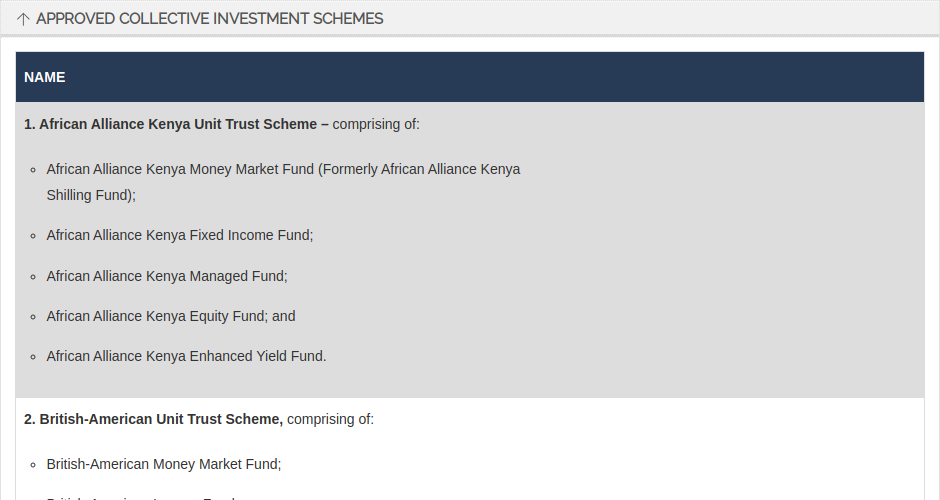

In [63]:
async def collective_investment_schemes_click_fn(page: Page):
    await page.waitForSelector('ul.module-accordion')
    elements = await page.querySelectorAll('li .accordion-title')
    # Iterate through the elements to find the one containing 'APPROVED COLLECTIVE INVESTMENT SCHEMES'
    for element in elements:
        text_content = await page.evaluate('(element) => element.textContent', element)
        if 'APPROVED COLLECTIVE INVESTMENT SCHEMES' in text_content:
            # Click on the target element
            await element.click()
            accordion_element = await page.waitForSelector('li.current.builder-accordion-active')
            await page.evaluate("""() => {
                document.querySelector('#headerwrap').style.display = 'none';
                document.querySelector('.pojo-a11y-toolbar-toggle').style.display = 'none';
            }""")
            await asyncio.sleep(1)
            return accordion_element
    print('Element not found')

# Take a screenshot
await web_screenshot_async(
    # Fund manager URL
    "https://www.cma.or.ke/licensees-market-players/", 
    action = collective_investment_schemes_click_fn,
    width = 1000, 
    screenshot_options = None,
    crop_options = { 'bottom': 500 })

##### licensees.cma.or.ke

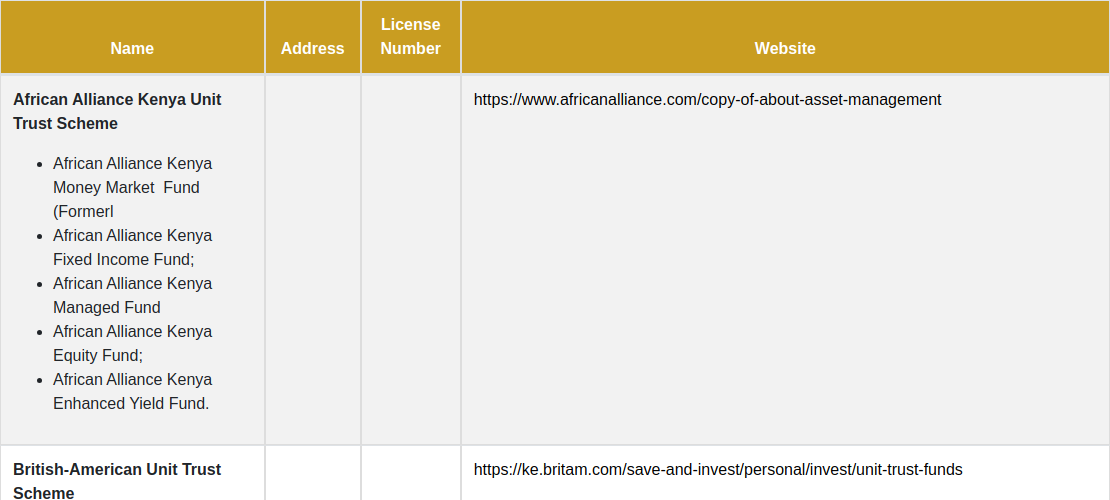

In [7]:
async def collective_investment_schemes_2(page: Page):
    return await page.querySelector('table')

# Take a screenshot
await web_screenshot_async(
    # Fund manager URL
    "https://licensees.cma.or.ke/licenses/15/", 
    action = collective_investment_schemes_2,
    width = 1500, 
    screenshot_options = None,
    crop_options = { 'bottom': 500 })

#### Crawling

Next, let's try grab the fund managers table into a dataframe that we can work with.
Below is the list of all the certified fund mangers in Kenya by CMA.^[Approved Fund Managers by CMA. <https://www.cma.or.ke/licensees-market-players/>]^[<https://licensees.cma.or.ke/licenses/15/>]

In [64]:
def extract_collective_scheme_name(para: Tag):
    full_name = ' '.join([i.get_text(strip=True) for i in para.find_all('strong')])
    return strip_start_end(full_name)

def make_collective_unit_obj(tbody_tr_td: Tag) -> collective_scheme_type:
    return {
        'Scheme': extract_collective_scheme_name(tbody_tr_td.find('p') or tbody_tr_td),
        'Funds': [
            strip_start_end(i.get_text(separator=' ', strip=True)) 
            for i 
            in tbody_tr_td.select('ul li')
        ]
    }

def fetch_collective_schemes_1():
    CMA_market_players_html: str = urlopen("https://www.cma.or.ke/licensees-market-players/").read()
    investment_schemes_table_html = BeautifulSoup(CMA_market_players_html, "html.parser")\
        .find('span', string="APPROVED COLLECTIVE INVESTMENT SCHEMES")\
        .find_parent('li')\
        .find('table')
    return [
        make_collective_unit_obj(tbody_tr_td)
        for tbody_tr_td 
        in investment_schemes_table_html.select('tbody tr td')
    ]

def fetch_collective_schemes_2():
    CMA_market_players_html: str = urlopen("https://licensees.cma.or.ke/licenses/15/").read()
    investment_schemes_table_html = BeautifulSoup(CMA_market_players_html, "html.parser")\
        .find('table')
    return [
        make_collective_unit_obj(tbody_tr_td)
        for tbody_tr_td 
        in investment_schemes_table_html.select('tbody tr > :first-child')
    ]

# For example: 
#       Orient Umbrella Collective Investment Scheme (formerly Alphafrica Umbrella Fund) => 
#       Orient Umbrella Collective Investment Scheme
def remove_quoted_str(str1: str): return re.sub(r'\(.*?(?!\)).*?$', '', str1 or '').strip()
def remove_rendadant_words(str1: str):
    return re.sub(
        r'\b(scheme|schemes|trust|trusts|specialized|special|funds|fund|unit|units|collective|investment)\b\s*', 
        '', 
        str1 or '',
        flags=re.IGNORECASE).strip()
def remove_special_words(str1: str):
    return re.sub(
        r'\b(specialized|special)\b\s*', 
        '', 
        str1 or '',
        flags=re.IGNORECASE).strip()

def make_merge_key(str1: str): return hacky_normalizer(remove_rendadant_words(remove_quoted_str(str1)))

def merge_collective_schemes(schemes_list: list[collective_scheme_type]) -> collective_scheme_type:
    all_names: dict[str, list[str]] = groupby(
        make_merge_key, [unit_obj['Scheme'] for unit_obj in schemes_list])
    all_schemes: dict[str, list[str]] = groupby(
        make_merge_key, [scheme for unit_obj in schemes_list for scheme in unit_obj['Funds']])
    return {
        'Scheme': sorted(
            [name for values in all_names.values() for name in values], 
            key = lambda x: len(remove_special_words(remove_quoted_str(x))), 
            reverse=True
        )[0],
        'Funds': [
            sorted(schemes, key = lambda x: len(x), reverse=True)[0]
            for schemes 
            in all_schemes.values()
        ]
    }

collective_schemes_1 = fetch_collective_schemes_1()
collective_schemes_2 = fetch_collective_schemes_2()
collective_schemes_1_2 = collective_schemes_1 + collective_schemes_2
collective_schemes_grouped_by_name = groupby(
    lambda x: make_merge_key(x['Scheme']), collective_schemes_1_2)
collective_schemes = [
    merge_collective_schemes(collective_schemes) 
    for collective_schemes 
    in collective_schemes_grouped_by_name.values()
    if len(collective_schemes) > 0 and len(collective_schemes[0]['Scheme']) > 0]
collective_schemes_df = pd.DataFrame(collective_schemes)
collective_schemes_df

Scheme  \
0            African Alliance Kenya Unit Trust Scheme   
1                  British-American Unit Trust Scheme   
2                               NCBA Unit Trust Funds   
3                            Zimele Unit Trust Scheme   
4                              ICEA Unit Trust Scheme   
5                     Standard Investment Trust Funds   
6                               CIC Unit Trust Scheme   
7                             Madison Unit Trust Fund   
8                    Dyer and Blair Unit Trust Scheme   
9                       Amana Unit Trust Funds Scheme   
10                         Diaspora Unit Trust Scheme   
11                   First Ethical Opportunities Fund   
12                           Genghis Unit Trust Funds   
13                             Mali Money Market Fund   
14                           Sanlam Unit Trust Scheme   
15                                  Nabo Africa Funds   
16                       Old Mutual Unit Trust Scheme   
17  Equity Investment Bank Collective Investment S...   
18                   Dry Associates Unit Trust Scheme   
19                                   Co-op Trust Fund   
20                           Apollo Unit Trust Scheme   
21                           Cytonn Unit Trust Scheme   
22  Orient Umbrella Collective Investment Scheme (...   
23               Wanafunzi Investment Unit Trust Fund   
24                              Absa Unit Trust Funds   
25                               Jaza Unit Trust Fund   
26                           Masaru Unit Trust Scheme   
27                             ADAM Unit Trust Scheme   
28  KCB Unit Trust Scheme (formerly Natbank Unit T...   
29                        GenAfrica Unit Trust Scheme   
30                 Amaka Unit Trust (Umbrella) Scheme   
31    Jubilee Unit Trust Collective Investment Scheme   
32                 Enwealth Capital Unit Trust Scheme   
33            Kuza Asset Management Unit Trust Scheme   
34  Etica Unit Trust Funds which has the following...   
35                     Lofty Corban Unit Trust Scheme   
36                             Faida Unit Trust Funds   
37                             Taifa Unit Trust Funds   
38                           Stanbic Unit Trust Funds   
39     Spearhead Africa Infrastructure (Special) Fund   
40                           Rencap Unit Trust Scheme   
41      Mayfair umbrella Collective investment scheme   
42                     Investcent Partners Trust Fund   
43             Investcent Alternative Investment Fund   
44             ICEA LION Collective Investment Scheme   
45                             GCIB Unit Trust Scheme   
46                               CPF Unit Trust Funds   
47                          Arvocap Unit Trust Scheme   
48                           MyXENO Unit Trust Scheme   

                                                Funds  
0   [African Alliance Kenya Money Market Fund (For...  
1   [British-American Money Market Fund, British-A...  
2   [NCBA Fixed Income Fund, NCBA Equity Fund, NCB...  
3   [Zimele Balanced Fund, Zimele Money Market Fun...  
4   [ICEA Money Market Fund, ICEA Equity Fund, ICE...  
5   [Standard Investment Equity Growth Fund, Stand...  
6   [CIC Money Market Fund, CIC Balanced Fund, CIC...  
7   [Madison Money Market Fund, Madison Fixed Inco...  
8   [Dyer and Blair Diversified Fund, Dyer and Bla...  
9   [Amana Money Market Fund, Amana Balanced Fund,...  
10  [Diaspora Money Market Fund, Diaspora Bond Fun...  
11                                                 []  
12  [GenCap Hazina Fund (Bond Fund), GenCap Eneza ...  
13                                                 []  
14  [Sanlam Money Market Fund (Sanlam Pesa Plus Fu...  
15  [Nabo Africa Money Market Fund, Nabo Africa Ba...  
16  [Old Mutual Equity Fund, Old Mutual Money Mark...  
17  [Equity Investment Bank Money Market Fund, Equ...  
18  [Dry Associates Money Market Fund (Kenya Shill...  
19  [Co-op Balanced Fund, Co-op Equity Fund, Co-op...  
20  [Apollo Money Ma

As of {{< meta date >}}, there are **49 unique** and approved unit trust schemes in Kenya, regulated by the Capital Markets Authority (CMA). The management of these schemes involves a complex ecosystem of financial institutions, each playing a distinct role:

1. **Approved Fund Managers**: These are entities specifically licensed by the CMA to manage collective investment schemes. They are responsible for making investment decisions and managing the day-to-day operations of the funds [^1].

2. **Investment Banks**: Investment banks are not the traditional commercial banks, but rather CMA-approved institutions that can engage in activities such as underwriting, market making, and fund management. For example, Genghis Capital Limited is listed by the CMA as an investment bank and manages its own unit trust fund, the Gencap Hela Imara Money Market Fund ^[[Genghis Capital Unit Trust Fund](https://genghis-capital.com/asset-management/money-market-fund/)][^1].

3. **Commercial Banks with Asset Management Arms**: Traditional banks may establish separate entities for asset management. For instance, KCB Bank has KCB Asset Management, which is approved by the CMA to manage unit trusts[^2]. Please note that there is also KCB Investment Bank[^1][^3].

4. **Non-Financial Companies with Investment Products**: Some companies outside the traditional financial sector have entered the investment market. A notable example is the Mali Money Market Fund^[[Frequently Asked Questions / Mali](https://www.safaricom.co.ke/media-center-landing/frequently-asked-questions/mali)] ^[[Safaricom to launch unit trust, new savings service](https://www.businessdailyafrica.com/bd/markets/capital-markets/safaricom-to-launch-unit-trust-new-savings-service-2288556)], owned wholly or in part by Safaricom PLC, Kenya's largest telecommunications company^[[M-PESA / M-PESA Services / Wealth / Mali](https://www.safaricom.co.ke/main-mpesa/m-pesa-services/wealth/mali)]. While Safaricom is not a licensed fund manager, they have partnered with Genghis Capital Limited to administer the Mali MMF^[[Safaricom's Mali unit trust asset base hits Sh1.4bn](https://www.businessdailyafrica.com/bd/markets/capital-markets/safaricom-s-mali-unit-trust-asset-base-hits-sh1-4bn--4582142)].

This complex landscape can sometimes lead to potential conflicts of interest. For instance, when an investment bank like Genghis Capital manages both its own funds and third-party funds like the Mali MMF, it raises questions about prioritization and fair treatment of all clients.
An additional layer of complexity arises when commercial banks (or their subsidiaries), such as KCB[^3], offer unit trust investment options alongside traditional savings and fixed deposit accounts. This dual offering presents a potential conflict of interest. Banks typically earn higher profits from traditional deposit accounts compared to the fees generated from managing unit trusts. This raises questions about how banks advise their clients on savings options. While money market funds often provide better returns for savers, banks might have an inherent incentive to promote their own deposit products. This situation underscores the importance of financial literacy and independent advice for consumers navigating these choices. Investors should be aware of this potential conflict and critically evaluate the recommendations they receive, considering whether the advice aligns more with their own financial interests or those of the bank.

It's also important to note that the market is dynamic, with some fund managers changing their offerings over time. For example, Zimele Asset Management Company has transitioned its Money Market Fund to a Fixed Income Fund^[[Zimele Savings Plan Transition: From Money Market to Fixed Income Fund](https://www.zimele.co.ke/zimele-savings-plan-transition-from-money-market-to-fixed-income-fund/)], highlighting the evolving nature of investment products in Kenya.

Given this complexity, potential investors should exercise caution and conduct thorough due diligence before committing their funds. This includes:

1. Verifying the regulatory status of the fund and its manager with the CMA
2. Understanding the fund's investment strategy and associated risks
3. Reviewing the fund's performance history and fee structure
4. Investigating any potential conflicts of interest
5. Seeking independent financial advice if necessary

:::{.callout-warning}
Always approach investments with caution, especially when important information is missing, unclear, or overly complicated. Remember that higher returns often come with higher risks, and past performance does not guarantee future results.
:::

[^1]: [CMA Approved Investment Banks](https://licensees.cma.or.ke/licenses/3/)
[^2]: [CMA Approved Fund Managers](https://licensees.cma.or.ke/licenses/8/)
[^3]: [KCB restructures investment units after buyout of NBK](https://www.businessdailyafrica.com/bd/corporate/companies/kcb-restructures-investment-units-after-buyout-of-nbk-4195606)

### Scheme Performance Data Collection

#### Challenges in Data Accessibility

The Kenyan financial regulatory environment mandates that unit trust schemes publish their daily yields in two national newspapers. However, this requirement presents several challenges for comprehensive data collection and analysis:

1. Limited Digital Presence: Many newspapers lack a substantial digital archive, necessitating physical access to print copies for data retrieval.
2. Cost Barriers: Accessing historical data often involves purchasing old newspaper records, making large-scale data collection financially prohibitive.
3. Time-Intensive Process: Manually gathering data from physical newspapers is a labor-intensive task, impractical for long-term, comprehensive analysis.
4. Inconsistent Reporting: Not all fund managers consistently publish their yields, leading to gaps in the data.

These factors collectively create a significant barrier to accessing and analyzing comprehensive, historical performance data for Kenyan unit trust schemes.

#### Cytonn Research: A Valuable Data Source

In light of these challenges, Cytonn Fund Managers' research publications have emerged as an invaluable resource. Since 2014, Cytonn has been conducting and freely publishing market research at <https://cytonnreport.com/>^[<https://web.archive.org/web/20241003181405/https://cytonnreport.com/>]. Key aspects of this data source include:

- Comprehensive Coverage: Over 600 reports covering various aspects of the Kenyan financial market.
- Historical Data: Consistent reporting since 2014, providing a substantial historical dataset.
- Free Access: Public availability of the reports, removing financial barriers to data access.
- Aggregated Information: Cytonn's reports often include compiled data from multiple sources, offering a more comprehensive view of the market.

While some fund managers publish current yield data on their websites^[<https://ke.cicinsurancegroup.com/mmf/>], the lack of historical data limits the usefulness of these sources for trend analysis and comprehensive research.

#### Data Collection Methodology

Given the richness and accessibility of Cytonn's research, we adopted the following approach for data collection:

1. Web Crawling: We developed a crawling mechanism to systematically access reports from both <https://cytonn.com/researches> and <https://cytonnreport.com/research>.
2. Ethical Considerations: Our crawling process was designed to respect Cytonn's server resources, avoiding any disruption to their services.
3. Data Extraction: We implemented a process to extract relevant tables and data points from each report.
4. Data Aggregation: The extracted information was compiled into a structured dataset suitable for analysis.
5. Compliance with Terms of Service: We carefully reviewed Cytonn's terms of service to ensure our use of the data aligns with their fair use policy[^1].

[^1]: Reproduction is prohibited other than in accordance with the copyright notice, which forms part of these terms and conditions. <https://cytonn.com/terms-of-use>

#### Screenshots of Cytonn Reports

##### cytonn.com page

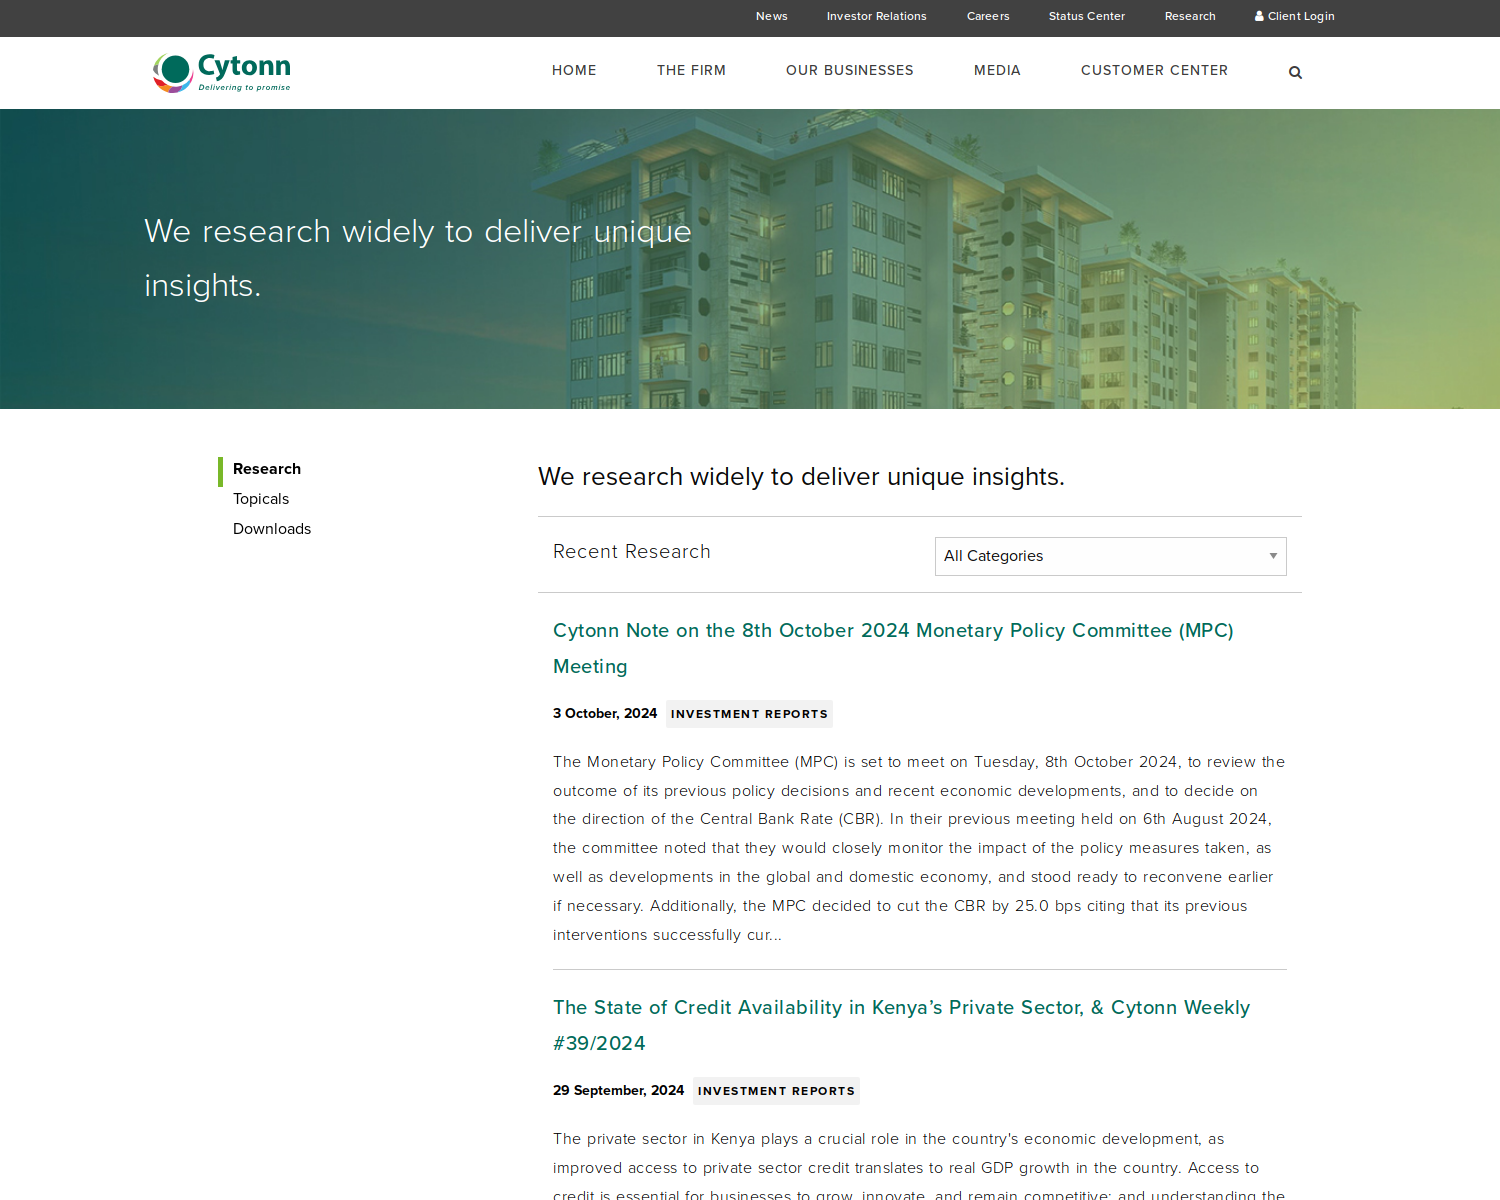

In [21]:
# Take a screenshot
await web_screenshot_async(
    "https://cytonn.com/researches",
    width = 1500,
    height = 1200,
    screenshot_options = {'fullPage': False })

##### cytonnreport.com page

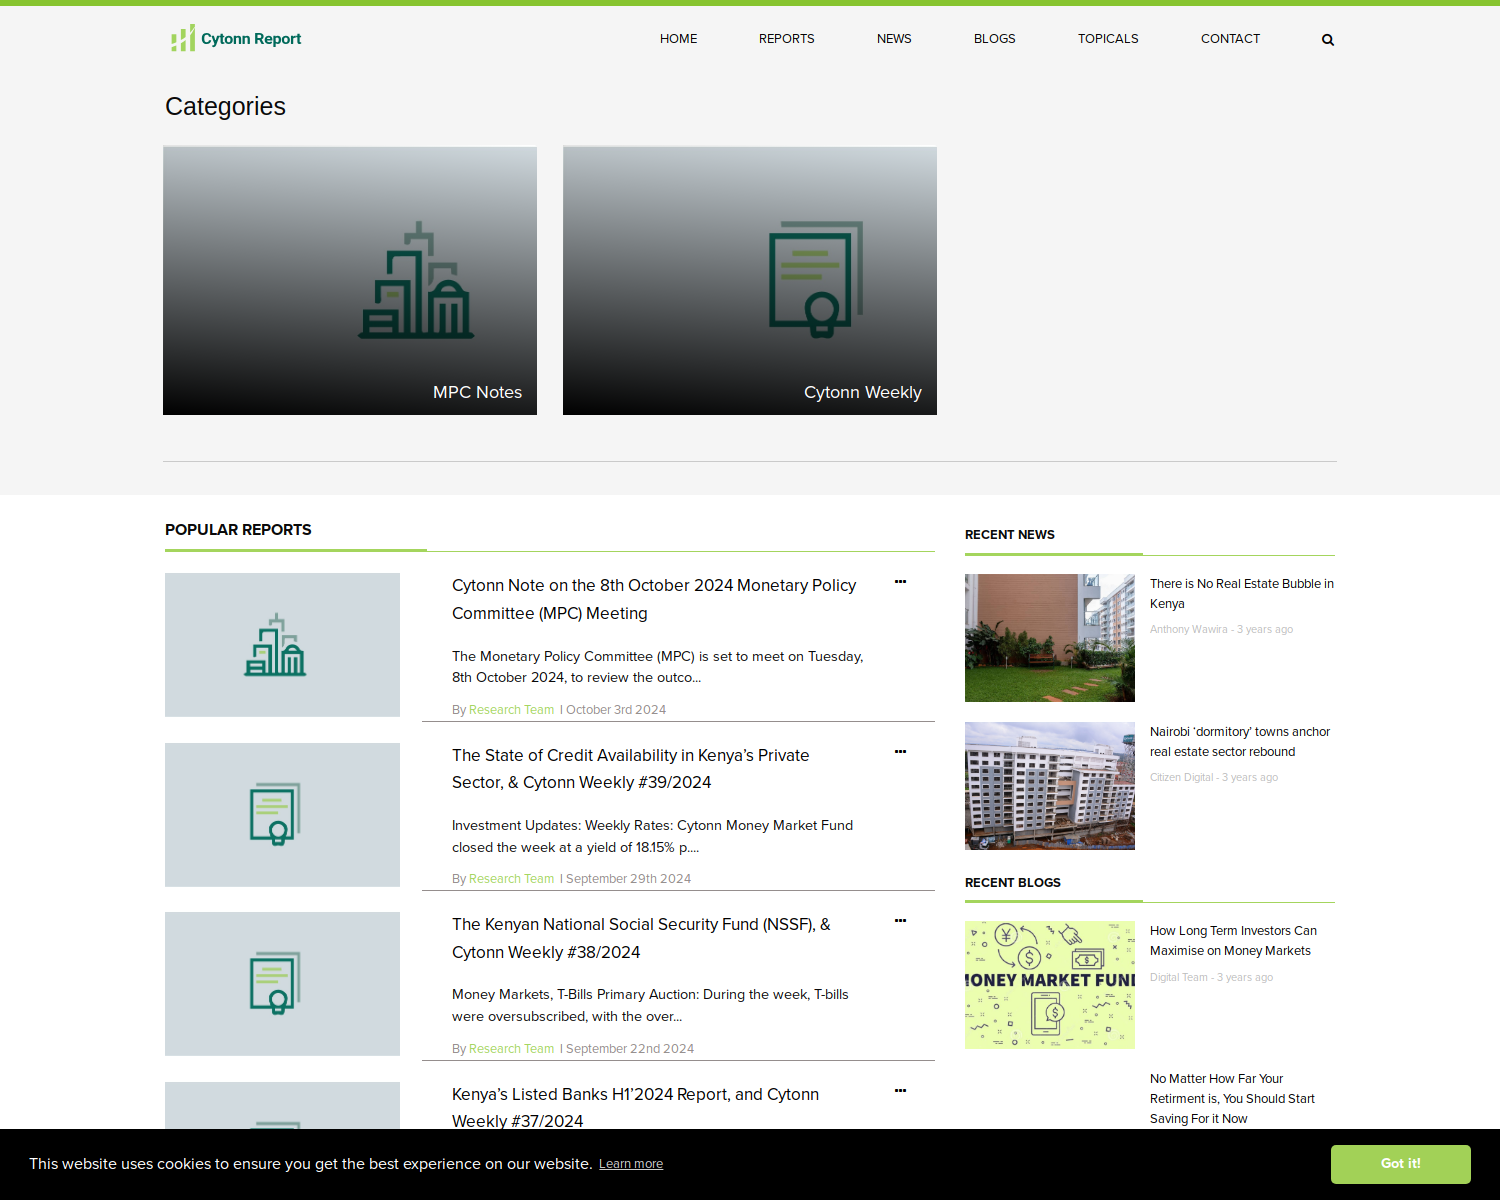

In [22]:
async def cytonnreport_fn(page: Page):
    await page.waitForSelector('.grid-x > .pagination')
    await asyncio.sleep(1)

# Take a screenshot
await web_screenshot_async(
    "https://cytonnreport.com/research",
    action = cytonnreport_fn,
    width = 1500,
    height = 1200,
    screenshot_options = {'fullPage': False })

##### Money Market Fund Yield Table

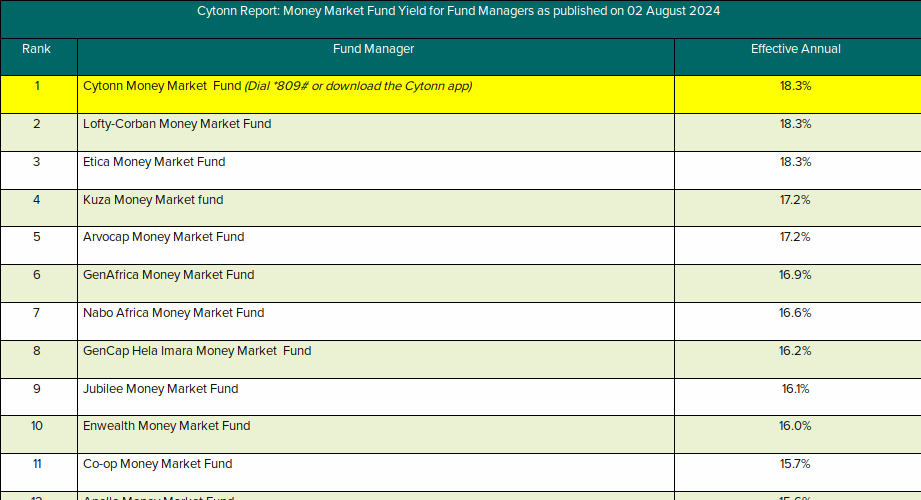

In [23]:
#| label: preview-image

# Define a function that selects a table by its header text
def select_table_by_title(target_header_text: str):
    # Define a nested asynchronous function that takes a Page object as an argument
    async def fn(page: Page):
        # Wait for any table element to be present on the page
        await page.waitForSelector('table')
        # Query and collect all table elements on the page
        table_elements = await page.querySelectorAll('table')
        # Iterate through each table element
        for table_element in table_elements:
            # Query and collect all header cells in the current table
            table_headers = await table_element.querySelectorAll('thead tr td')
            # Iterate through each header cell
            for table_header in table_headers:
                # Extract the text content of the current header cell
                header_text:str = await page.evaluate('(element) => element.textContent', table_header)
                # Check if the header text starts with the target text
                if header_text.startswith(target_header_text):
                    # If a match is found, return the current table element
                    return table_element
    return fn

await web_screenshot_async(
    # URL to take a screenshot of
    "https://cytonnreport.com/research/cytonn-monthly-",
    # Action deciding WHAT (element) or WHEN (eg: click) to take the screenshot
    action = select_table_by_title('Cytonn Report: Money Market Fund Yield'),
    width = 1000, 
    screenshot_options = None,
    crop_options = { 'bottom': 500 })

#### Crawling

At <https://cytonn.com/researches>, we can crawl and parse HTML, but it could be very slow. We notice that <https://cytonnreport.com/research>, the exact same data is displayed, but using a background request, <https://cytonnreport.com/get/allreports>. We can use this to crawl multiple reports faster.

In [65]:
async def get_all_cytonn_reports(per_page_count: int = 10):
    """
    Retrieves all Cytonn reports from the Cytonn Report website.

    Args:
        per_page_count (int, optional): The number of reports to retrieve per page. Defaults to 10.

    Returns:
        list: A list of all the retrieved reports.
    """
    ...
    page, browser = await get_browser_page_async()
    reports_url = "https://cytonnreport.com/get/allreports"
    reports_headers: dict = None
    reports_method: str = None
    async def catch_request(request: Request):
        nonlocal reports_headers
        nonlocal reports_method
        if request.url == reports_url:
            reports_headers = request.headers.copy()
            reports_method = request.method
            await request.continue_()
        else:
            await request.continue_()
    async def get_cytonn_reports(current_page: int):
        javascript_fetch_fn = f'''
            async () => {{
                try {{
                    const response = await fetch(
                        "{reports_url}", 
                        {{
                            "headers": {json.dumps(reports_headers)},
                            "method": "{reports_method}",
                            "body": {json.dumps(json.dumps(
                                {
                                    "pagination": {
                                        "per_page": per_page_count, 
                                        "current_page": current_page
                                    }
                                }))},
                            "referrer": "https://cytonnreport.com/research",
                            "referrerPolicy": "no-referrer-when-downgrade",
                            "mode": "cors",
                            "credentials": "include"
                        }});
                    if (!response.ok) {{
                        throw new Error(`HTTP error! status: ${{response.status}}`);
                    }}
                    const json = await response.json();
                    return json;
                }} catch (error) {{
                    console.error('Fetch error:', error);
                    throw error; // Re-throw to allow calling code to handle it
                }}
            }}
        '''
        response_json = await page.evaluate(javascript_fetch_fn)
        return response_json
    # Enable request interception
    await page.setRequestInterception(True)
    # Attach the request handler
    page.on('request', lambda request: asyncio.ensure_future(catch_request(request)))
    # Navigate to the desired URL
    await page.goto("https://cytonnreport.com/research")
    while not reports_headers:
        await asyncio.sleep(1)
    current_page = 1
    all_reports = []
    pbar: tqdm = None
    while True:
        reports_response = await get_cytonn_reports(current_page)
        reports = reports_response['data'] if reports_response else []
        if len(reports) > 0:
            total = reports_response['total']
            pbar = pbar or tqdm(total=total)
            pbar.update(len(reports))
            all_reports.extend(reports)
            last_page = reports_response['last_page']
            if last_page == current_page:
                break
            current_page += 1
        else:
            break
        await asyncio.sleep(0.4)
    await browser.close()
    if pbar:
        pbar.close()
    return all_reports

all_cytonn_reports = await get_all_cytonn_reports()
print(f'There are {len(all_cytonn_reports)} reports')

100%|██████████| 652/652 [02:56<00:00,  3.69it/s]

There are 652 reports


In [67]:
# converting the JSON into dataframe
all_cytonn_reports_df = pd.DataFrame(all_cytonn_reports)
with pd.option_context(
  'display.max_columns', None, 
  'display.max_colwidth', 100):
  display(all_cytonn_reports_df)

id                                                       slug  \
0    735                                           cytonn-note-on-1   
1    734  the-state-of-credit-availability-in-kenyas-private-sector   
2    733                                        the-kenyan-national   
3    732                                      kenyas-listed-banks-5   
4    731                                retirement-benefits-schemes   
..   ...                                                        ...   
647    4                                         update-nov-21-2014   
648    3                                          update-nov-7-2014   
649    2                                         update-oct-24-2014   
650    1                                     rebasing-of-kenyas-gdp   
651  316                                         kcb-group-earnings   

                                                                                     name  \
0             Cytonn Note on the 8th October 2024 Monetary Policy Committee (MPC) Meeting   
1    The State of Credit Availability in Kenya’s Private Sector, & Cytonn Weekly #39/2024   
2               The Kenyan National Social Security Fund (NSSF), & Cytonn Weekly #38/2024   
3                         Kenya’s Listed Banks H1’2024 Report, and Cytonn Weekly #37/2024   
4       Retirement Benefits Schemes Q2’2024 Performance Report and Cytonn Weekly #36/2024   
..                                                                                    ...   
647                                                                  Cytonn Weekly Update   
648                                                                  Cytonn Weekly Update   
649                                                                  Cytonn Weekly Update   
650                                                               Rebasing of Kenya's GDP   
651                                                     KCB Group Earnings Note – H1’2019   

                 author researchdate  active  created_by  series_id  \
0         Research Team   2024-10-03       1          92          3   
1         Research Team   2024-09-29       1          92          1   
2         Research Team   2024-09-22       1          92          1   
3      Investments team   2024-09-15       1          94          1   
4      Investments Team   2024-09-08       1          95          1   
..                  ...          ...     ...         ...        ...   
647          Shiv Arora   2014-11-21       1           1          1   
648          Shiv Arora   2014-11-07       1           1          1   
649          Shiv Arora   2014-10-24       1           1          1   
650          Shiv Arora   2014-10-17       1           1          1   
651  Cytonn Investments         None       1          68          3   

       campaign  sent thumbnail           created_at meta_title meta_keywords  \
0          None     0      None  2024-10-03 16:16:07       None          None   
1          2446     1      None  2024-09-29 11:12:30       None          None   
2          2434     1      None  2024-09-22 13:49:16       None          None   
3          2419     1      None  2024-09-15 10:25:35       None          None   
4          2407     1      None  2024-09-08 12:39:42       None          None   
..          ...   ...       ...                  ...        ...           ...   
647        None     0      None  2017-10-30 16:02:03       None          None   
648        None     0      None  2017-10-30 16:02:03       None          None   
649        None     0      None  2017-10-30 16:02:03       None          None   
650        None     0      None  2017-10-30 16:02:03       None          None   
651  2f9339c3d8     0      None  2019-08-18 12:02:25       None          None   

    meta_description og_description  \
0               None           None   
1               None           None   
2               None           None   
3               None           None   
4              

As can be observed, the dataset above is a bit complex and diffucult to uderstand or analyze. This is because alot of information is contained in the reports. There is real estate data, money market funds dataset, fund managers over the years,  As such, we will try to extract money market funds (KES) from the reports.

In [68]:
# This cofirms all the records have are unique
len(all_cytonn_reports_df), len(all_cytonn_reports), len(all_cytonn_reports_df['id'].unique())

(652, 652, 652)

## Exploratore and Clean the Dataset

The goal here is to extract the details of Effective/Norminal/Annual Rate of Money Market Funds (KES) and Assets Under Management for the entire schemes

### Summary of numerical columns

In [69]:
all_cytonn_reports_df.describe()

id  active  created_by   series_id        sent  date_holder
count  652.000000   652.0  652.000000  652.000000  652.000000   652.000000
mean   350.894172     1.0   45.191718    1.309816    0.529141    16.115031
std    209.417294     0.0   35.976119    0.724189    0.499533     8.929522
min      1.000000     1.0    1.000000    1.000000    0.000000     1.000000
25%    163.750000     1.0    1.000000    1.000000    0.000000     8.000000
50%    350.500000     1.0   62.000000    1.000000    1.000000    17.000000
75%    524.250000     1.0   74.750000    1.000000    1.000000    24.000000
max    735.000000     1.0   97.000000    3.000000    1.000000    31.000000

### Preview the Columns

In [70]:
all_cytonn_reports_df.columns

Index(['id', 'slug', 'name', 'author', 'researchdate', 'active', 'created_by',
       'series_id', 'campaign', 'sent', 'thumbnail', 'created_at',
       'meta_title', 'meta_keywords', 'meta_description', 'og_description',
       'url', 'og_image', 'updated_at', 'deleted_at', 'title', 'category',
       'summary', 'body', 'date_holder', 'date', 'creator', 'status', 'series',
       'topics'],
      dtype='object')

In [71]:
all_cytonn_reports_df.iloc[0]

id                                                                735
slug                                                 cytonn-note-on-1
name                Cytonn Note on the 8th October 2024 Monetary P...
author                                                  Research Team
researchdate                                               2024-10-03
active                                                              1
created_by                                                         92
series_id                                                           3
campaign                                                         None
sent                                                                0
thumbnail                                                        None
created_at                                        2024-10-03 16:16:07
meta_title                                                       None
meta_keywords                                                    None
meta_description    

### Data types

In [72]:
all_cytonn_reports_df.dtypes

id                   int64
slug                object
name                object
author              object
researchdate        object
active               int64
created_by           int64
series_id            int64
campaign            object
sent                 int64
thumbnail           object
created_at          object
meta_title          object
meta_keywords       object
meta_description    object
og_description      object
url                 object
og_image            object
updated_at          object
deleted_at          object
title               object
category            object
summary             object
body                object
date_holder          int64
date                object
creator             object
status              object
series              object
topics              object
dtype: object

Below is a tree structure of one record, to visualize the objects and their inner properties

In [73]:
json_structure = json2txttree(all_cytonn_reports[:1])
min_topics = min(len(i.get('topics', [])) for i in all_cytonn_reports)
max_topics = max(len(i.get('topics', [])) for i in all_cytonn_reports)
json_structure = json_structure.replace('└─  (array)', f'└─  (array) [{len(all_cytonn_reports)} items]')
json_structure = json_structure.replace('"topics" (array)', f'"topics" (array) [between {min_topics} - {max_topics} items]')

print(json_structure)

└─  (array) [652 items]
   └─  (object)
      ├─ "id" (number)
      ├─ "slug" (string)
      ├─ "name" (string)
      ├─ "author" (string)
      ├─ "researchdate" (string)
      ├─ "active" (number)
      ├─ "created_by" (number)
      ├─ "series_id" (number)
      ├─ "campaign" (number)
      ├─ "sent" (number)
      ├─ "thumbnail" (number)
      ├─ "created_at" (string)
      ├─ "meta_title" (number)
      ├─ "meta_keywords" (number)
      ├─ "meta_description" (number)
      ├─ "og_description" (number)
      ├─ "url" (string)
      ├─ "og_image" (string)
      ├─ "updated_at" (string)
      ├─ "deleted_at" (number)
      ├─ "title" (string)
      ├─ "category" (string)
      ├─ "summary" (string)
      ├─ "body" (string)
      ├─ "date_holder" (number)
      ├─ "date" (string)
      ├─ "creator" (string)
      ├─ "status" (string)
      ├─ "series" (object)
      │  ├─ "id" (number)
      │  ├─ "name" (string)
      │  ├─ "description" (string)
      │  ├─ "thumbnail" (string)
   

A full article is formed by articles. Each `topics` is a subsection, with `title` being the header and `body` being the content. We will merge all bodies from the articles to form the entire report HTML, which we will parse to extract the Money Market Funds yields tables. In addition, we are also going to add the main `body` and main `summary` and topics `summary` to encure we capture any table we might miss.

In [74]:
CYTONN_RECORD_LITERALS = Literal['summary', 'body', 'topics', 'researchdate']
def get_report_HTML(report: dict[CYTONN_RECORD_LITERALS, Any]) -> str:
    summary_html = report['summary']
    body_html = report['body']
    topics_html = ''.join([f"{i['summary']} \n\n {i['body']}" for i in report['topics']])
    return f"{summary_html} \n {body_html} \n {topics_html}"

# from IPython.display import HTML
# HTML(get_report_HTML(all_cytonn_reports[0]))

### Parsing Dates

There are some summary tables that have dates such as `Q1'2023`, `Q1'2023 (%)`, `FY'2023`, `FY'2023 (%)`, `Q1'2024`, `Q1'2024 (%)`

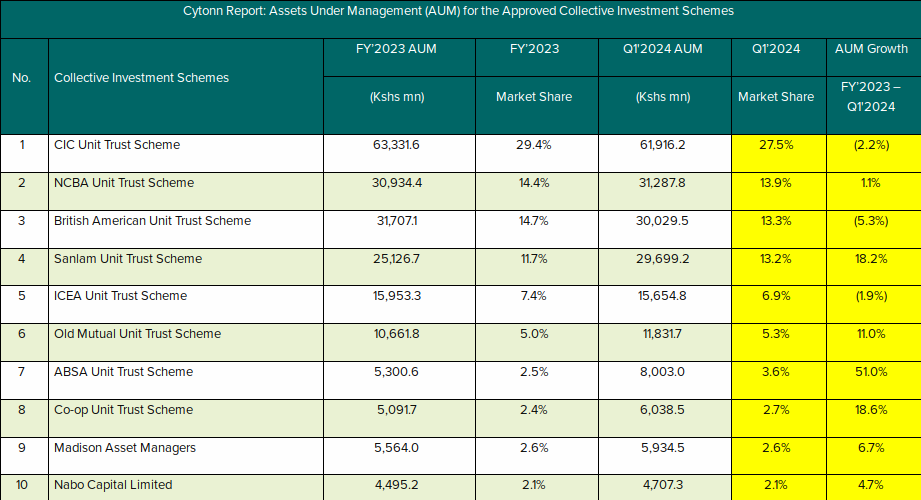

In [75]:
await web_screenshot_async(
    # URL to take a screenshot of
    "https://cytonnreport.com/research/q1-2024-unit-trust-funds-performance-note",
    # Action deciding WHAT (element) or WHEN (eg: click) to take the screenshot
    action = select_table_by_title('Cytonn Report: Assets Under Management (AUM) for the Approved Collective Investment Schemes'),
    width = 1000, 
    screenshot_options = None,
    crop_options = { 'bottom': 500 })

Below function will help parse such time ranges:

In [76]:
def get_date_range(month, year):
    # Convert month name to number
    month_num = [i.lower() for i in month_abbr].index(month.lower())\
        if len(month) > 0 and any([i.lower() == month.lower() for i in month_abbr])\
        else datetime.strptime(month, '%B').month
    # Get the last day of the month
    _, last_day = monthrange(int(year), month_num)
    # Create date objects for the first and last day of the month
    start_date = date(int(year), month_num, 1)
    end_date = date(int(year), month_num, last_day)
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
parse_date_pattern_months = (
    "JAN|JANUARY|FEB|FEBRUARY|MAR|MARCH|APR|APRIL|MAY|"
    "JUN|JUNE|JUL|JULY|AUG|AUGUST|SEP|SEPTEMBER|"
    "OCT|OCTOBER|NOV|NOVEMBER|DEC|DECEMBER"
)
parse_date_pattern = rf'(?:(\d{{2}})[_|\s|-]*)?({parse_date_pattern_months})[_|\s|-]*(\d{{4}})'

def parse_fiscal_period_dates(date_string: str) -> (tuple[str, str] | None):
    """
    This function parses a date string representing a fiscal period 
    (Fiscal/Financial Year, Quarter, or Half-year), year, or date and returns the corresponding 
    start and end dates.
    """
    extracted_date = re.search('^' + parse_date_pattern + '$', date_string, re.IGNORECASE)
    if extracted_date:
        search_date, search_month, search_year = extracted_date.groups()
        if search_date:
            month_num = datetime.strptime(search_month, '%B').month
            return datetime(int(search_year), month_num, int(search_date)).strftime('%Y-%m-%d')
        else:
            return get_date_range(search_month, search_year)
    if re.match(r"^\d{4}$", date_string, re.IGNORECASE):
        date_string = f"FY'{date_string}"
    # Define a regex pattern to match fiscal periods (FY, Q1-Q4, H1-H2) followed by a year, or just an year
    pattern = r"^(FY|Q[1-4]|H[1-2])['|_|\s]*(\d{4})$"
    # Try to match the input string against the pattern
    match = re.match(pattern, date_string, re.IGNORECASE)
    # If no match is found, return None
    if not match:
        return None
    # Extract the period type and year from the match
    period, year = match.groups()
    year = int(year)
    # Handle Fiscal Year (FY) case
    if period.upper() == 'FY':
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31)
    # Handle Quarter (Q1-Q4) cases
    elif period.upper().startswith('Q'):
        quarter = int(period[1])
        start_month = (quarter - 1) * 3 + 1
        start_date = datetime(year, start_month, 1)
        # Calculate end date of the quarter
        end_date = start_date.replace(month=start_month + 2) + timedelta(days=32)
        end_date = end_date.replace(day=1) - timedelta(days=1)
    # Handle Half-year (H1-H2) cases
    elif period.upper().startswith('H'):
        half = int(period[1])
        start_month = (half - 1) * 6 + 1
        start_date = datetime(year, start_month, 1)
        # Calculate end date of the half-year
        end_date = start_date.replace(month=start_month + 5) + timedelta(days=32)
        end_date = end_date.replace(day=1) - timedelta(days=1)
    # Return start and end dates formatted as strings
    return (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

def TEST_parse_fiscal_period_dates():
    # Test the function
    test_dates = [
        "FY'2019", "Q1'2020", "H1'2019", "fy 2018", "q32021", "h2_2022", "2020", '2019',
        'JUNE_2020', '01_NOVEMBER_2017', "H3'2020"
    ]
    for expanding_value in test_dates:
        result = parse_fiscal_period_dates(expanding_value)
        if result:
            print(f"{expanding_value}: {result}")
        else:
            print(f"{expanding_value}: Invalid format")
TEST_parse_fiscal_period_dates()

FY'2019: ('2019-01-01', '2019-12-31')
Q1'2020: ('2020-01-01', '2020-03-31')
H1'2019: ('2019-01-01', '2019-06-30')
fy 2018: ('2018-01-01', '2018-12-31')
q32021: ('2021-07-01', '2021-09-30')
h2_2022: ('2022-07-01', '2022-12-31')
2020: ('2020-01-01', '2020-12-31')
2019: ('2019-01-01', '2019-12-31')
JUNE_2020: ('2020-06-01', '2020-06-30')
01_NOVEMBER_2017: 2017-11-01
H3'2020: Invalid format


### Parsing a Effective Annual Rate(KES Money Market Fund) and Total Assets Under Management (Collective Investment Schemes)

The `Extracted_Scheme_Entry` class below represents and validates a financial record entry. It validates `record type` (_Assets Under Management_ or _Effective Annual Rate_), `date`, `value`, and `scheme`. The class also maintains lists of non-existent fund managers and invalid records. Assets under management (AUM) is the market value of the investments managed by the fund manager on behalf of clients, inluding MMF, FIXED, balanced, equity, etc.

In [77]:
class Extracted_Scheme_Entry:
    """
    A class to represent and validate financial entry information.
    
    Class Attributes:
    INVALID_FUNDS (list[str]): Stores funds not found in the mapping.
    INVALID_DATES (list[str]): Stores entry dates not valid.
    INVALID_VALUES (list[str]): Stores entry values not valid.
    TYPE_ASSETS_UNDER_MANAGEMENT (str): Constant for Assets Under Management type.
    TYPE_EFFECTIVE_ANNUAL_RATE (str): Constant for Effective Annual Rate type.
    """
    INVALID_SCHEMES: list[str] = []
    INVALID_DATES: list[str] = []
    INVALID_VALUES: list[str] = []
    TYPE_ASSETS_UNDER_MANAGEMENT: str = 'ASSETS_UNDER_MANAGEMENT' # Assets Under Management
    TYPE_EFFECTIVE_ANNUAL_RATE: str = 'EFFECTIVE_ANNUAL_RATE' # Effective Annual Rate

    def __init__(self, 
                 entry_type: Literal['ASSETS_UNDER_MANAGEMENT', 'EFFECTIVE_ANNUAL_RATE'], 
                 entry_date: str, 
                 entry_value: str, 
                 entry_scheme: str,
                 scheme_filter_function: Callable[[str], list[str]]):
        """
        Initialize a RecordEntry instance with validated attributes.
        
        Args:
        entry_type (str): Type of the record (TYPE_ASSETS_UNDER_MANAGEMENT or TYPE_EFFECTIVE_ANNUAL_RATE).
        entry_date (str): Date of the record (2024-03-01) or Financial period (H1'2024).
        entry_value (str): Value of the record.
        entry_scheme (str): Name of the MMF(KES) fund
        fund_manager_filter_predicate (Callable): A predicate to filter and return matched MMF(KES) fund for validation.
        """
        self.entry_type = Extracted_Scheme_Entry.validate_type(entry_type)
        self.entry_date = Extracted_Scheme_Entry.validate_date(entry_date)
        self.entry_value = Extracted_Scheme_Entry.validate_value(entry_value)
        self.entry_scheme = Extracted_Scheme_Entry.validate_scheme(entry_scheme, scheme_filter_function)
        if self.entry_date is None:
            Extracted_Scheme_Entry.INVALID_DATES.append(entry_date)
        if self.entry_value is None:
            Extracted_Scheme_Entry.INVALID_VALUES.append(entry_value)
        if self.entry_scheme is None:
            Extracted_Scheme_Entry.INVALID_SCHEMES.append(entry_scheme)

    def is_valid(self) -> bool:
        """
        Check if the record is valid (all attributes are non-empty).
        """
        is_valid = \
            bool(self.entry_type) \
            and bool(self.entry_date) \
            and bool(self.entry_value) \
            and bool(self.entry_scheme)
        return is_valid

    @staticmethod
    def validate_scheme(value: str, filter_predicate: Callable[[str], list[str]]) -> str|None:
        """
        Validate and standardize the date or financial period.
        """
        try:
            value = str(value or '').lower()
            # These represent USD MMF's
            EXCLUDES = ['Dollar', 'USD']
            is_USD_MMF = any((exclude.lower() in value) for exclude in EXCLUDES)
            if not is_USD_MMF:
                names = filter_predicate(value)
                if len(names) == 1:
                    return names[0]
                if len(names) > 1:
                    print(f'"{value}" has more that two matches! {names}')
            return None
        except:
            return None
    
    @staticmethod
    def validate_date(value: str) -> str|tuple[str, str]|None:
        """
        Validate and standardize the date
        """
        try:
            return parse_fiscal_period_dates(value)\
                    or datetime.strptime(value, "%Y-%m-%d").strftime('%Y-%m-%d')\
                    or None
        except:
            return None

    @staticmethod
    def validate_value(value: str|float) -> str|None:
        """
        Validate and clean the entry value.
        """
        try:
            if type(value) == float:
                    return value
            # remove percentage sign
            value = value.rstrip('%')
            # remove comma and white space
            value = ''.join([i for i in value if i not in [' ', ',', '-']])
            return float(value) if len(value) > 0 else None
        except:
            return None

    @staticmethod
    def validate_type(value: str) -> Literal['ASSETS_UNDER_MANAGEMENT', 'EFFECTIVE_ANNUAL_RATE']:
        """
        Validate the record type.
        
        Args:
        value (str): The record type to validate.
        
        Raises:
        TypeError exception.
        """
        value = (value or '').upper()
        if value in [Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE]:
            return value
        raise TypeError(f"{value} is not proper entry Type!")
    
def TEST_MoneyMarketFund_KES_RecordEntry():
    # Test the class
    test_cases = [
        {
            "entry_type": Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT,
            "entry_date": "2024-03-01",
            "entry_value": "1,000,000",
            "entry_scheme": "britam",
        },
        {
            "entry_type": Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE,
            "entry_date": "H1'2024",
            "entry_value": "5.5%",
            "entry_scheme": "old mutual",
        },
        {
            "entry_type": Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT,
            "entry_date": "invalid-date",
            "entry_value": "1,000,000",
            "entry_scheme": "sanlam",
            "invalid": "invalid date"
        },
        {
            "entry_type": Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT,
            "entry_date": "2024-03-01",
            "entry_value": "invalid-value",
            "entry_scheme": "britam",
            "invalid": "invalid value"
        },
        {
            "entry_type": Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT,
            "entry_date": "2024-03-01",
            "entry_value": "1,000,000",
            "entry_scheme": "unknown scheme",
            "invalid": "unmapped scheme"
        },
        {
            "entry_type": Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT,
            "entry_date": "2024-03-01",
            "entry_value": "1,000,000",
            "entry_scheme": "britam sanlam",
            "invalid": "2 funds matched"
        },
        {
            "entry_type": Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT,
            "entry_date": "2024-03-01",
            "entry_value": "1,000,000",
            "entry_scheme": "Britam USD Dollar Fund",
            "invalid": "USD MMF"
        },
    ]
    # Define the fund filter function
    test_fund_map = [
        (
            'Britam MMF(KES)',
            ['britam', 'british-american', 'british', 'american']
        ),
        (
            'UAP Old Mutual MMF(KES)',
            ['old mutual', 'uap old mutual', 'uap']
        ),
        (
            'Sanlam MMF(KES)',
            ['sanlam', 'sanlam investments']
        )
    ]

    def test_fund_filter(value: str):
        value = value.lower()
        names = [name for name, aliases in test_fund_map if any(alias in value for alias in aliases)]
        return names

    # Run tests
    for test_case in test_cases:
        entry = Extracted_Scheme_Entry(
            test_case["entry_type"],
            test_case["entry_date"],
            test_case["entry_value"],
            test_case["entry_scheme"],
            test_fund_filter
        )
        cases = [entry.entry_date, entry.entry_value, entry.entry_scheme]
        invalid = f" ({test_case.get('invalid')})" if test_case.get('invalid') else ''
        print(f"Valid: {entry.is_valid()}{invalid}, {cases}")

    # Print invalid entries
    print("\nInvalid Funds:", Extracted_Scheme_Entry.INVALID_SCHEMES)
    print("\nInvalid Dates:", Extracted_Scheme_Entry.INVALID_DATES)
    print("\nInvalid Values:", Extracted_Scheme_Entry.INVALID_VALUES)
    Extracted_Scheme_Entry.INVALID_SCHEMES = []
    Extracted_Scheme_Entry.INVALID_DATES = []
    Extracted_Scheme_Entry.INVALID_VALUES = []
TEST_MoneyMarketFund_KES_RecordEntry()

Valid: True, ['2024-03-01', 1000000.0, 'Britam MMF(KES)']
Valid: True, [('2024-01-01', '2024-06-30'), 5.5, 'UAP Old Mutual MMF(KES)']
Valid: False (invalid date), [None, 1000000.0, 'Sanlam MMF(KES)']
Valid: False (invalid value), ['2024-03-01', None, 'Britam MMF(KES)']
Valid: False (unmapped scheme), ['2024-03-01', 1000000.0, None]
"britam sanlam" has more that two matches! ['Britam MMF(KES)', 'Sanlam MMF(KES)']
Valid: False (2 funds matched), ['2024-03-01', 1000000.0, None]
Valid: False (USD MMF), ['2024-03-01', 1000000.0, None]

Invalid Funds: ['unknown scheme', 'britam sanlam', 'Britam USD Dollar Fund']

Invalid Dates: ['invalid-date']

Invalid Values: ['invalid-value']


We then create a fund collective schemes map with a tuple of `name` and `aliases` because the records don't have a simple or stardard naming in the Cytonn reports. As such, we need to use very unique and simple names that we can use to match abitrary Money market funds names from the crawled data.

In [78]:
SCHEME_NAME_ALIAS_MAP = [
    # The African Alliance (AA) Kenya Shillings Fund is a money market fund by 
    # African Alliance Kenya Investment Bank Limited (the fund manager) 
    # launched on 27th April 2015.
    # https://centwarrior.com/aa-kenya-shillings-fund/
    # https://www.linkedin.com/posts/centwarrior_aa-kenya-shillings-fund-explained-in-2024-activity-7169322082814705664-8nwu?utm_source=share&utm_medium=member_desktop
    # https://cytonn.com/topicals/investment-risk-analysis
    (
        'African Alliance Kenya Unit Trust Scheme', 
        ['african', 'alliance', 'aa kenya']
    ),
    (
        'British-American Unit Trust Scheme', 
        ['britam', 'british-american', 'british', 'american']
    ),
    (
        'NCBA Unit Trust Funds', 
        ['ncba', 'cba', 'commercial bank of africa']
    ),
    (
        'Zimele Unit Trust Scheme', 
        ['zimele']
    ),
    (
        'ICEA Unit Trust Scheme', 
        ['icea']
    ),
    (
        'Standard Investment Trust Funds', 
        ['standard', 'mansa']
    ),
    (
        'CIC Unit Trust Scheme', 
        ['cic']
    ),
    (
        'Madison Unit Trust Fund', 
        ['Madison', 'madisson']
    ),
    (
        'Dyer and Blair Unit Trust Scheme', 
        ['dyer', 'blair']
    ),
    (
        'Amana Unit Trust Funds Scheme', 
        ['amana']
    ),
    (
        'Diaspora Unit Trust Scheme', 
        ['diaspora']
    ),
    (
        'First Ethical Opportunities Fund', 
        ['ethical', 
         # 'first', 'opportunities'
        ]
    ),
    # https://www.cma.or.ke/licensees-market-players/
    # https://genghis-capital.com/asset-management/money-market-fund/
    (
        'Genghis Unit Trust Funds', 
        ['hela','genghis', 'hazina', 'hisa', 'iman', 'gencap', 'compliant', 'eneza', 'genCap', 'imara']
    ),
    # https://www.businessdailyafrica.com/bd/markets/capital-markets/safaricom-s-mali-unit-trust-asset-base-hits-sh1-4bn--4582142
    (
        'Mali Money Market Fund', 
        ['mali']
    ),
    (
        'Sanlam Unit Trust Scheme', 
        ['sanlam']
    ),
    (
        'Nabo Africa Funds', 
        ['nabo']
    ),
    (
        'Old Mutual Unit Trust Scheme', 
        ['mutual', 'old', 'Faulu']
    ),
    # https://equitygroupholdings.com/ke/investor-relations/eib
    # https://www.cma.or.ke/licensees-market-players/
    (
        'Equity Investment Bank Collective Investment Scheme', 
        ['equity']
    ),
    # https://www.cma.or.ke/licensees-market-players/
    (
        'Dry Associates Unit Trust Scheme', 
        ['dry associates', 'dry', 'associates']
    ),
    (
        'Co-op Trust Fund', 
        ['co-op', 'gratuity', 'Coop']
    ),
    (
        'Apollo Unit Trust Scheme', 
        ['aggressive', 'apollo']
    ),
    (
        'Cytonn Unit Trust Scheme', 
        ['cytonn']
    ),
    (
        'Orient Umbrella Collective Investment Scheme (formerly Alphafrica Umbrella Fund)', 
        ['orient', 'kasha', 'alpha', 'alphafrica']
    ),
    (
        'Wanafunzi Investment Unit Trust Fund', 
        ['wanafunzi']
    ),
    (
        'Absa Unit Trust Funds', 
        ['absa']
    ),
    (
        'Jaza Unit Trust Fund', 
        ['jaza']
    ),
    (
        'Masaru Unit Trust Scheme', 
        ['masaru']
    ),
    (
        'ADAM Unit Trust Scheme', 
        ['adam']
    ),
    (
        'KCB Unit Trust Scheme (formerly Natbank Unit Trust Scheme)', 
        ['kcb', 'natbank']
    ),
    (
        'GenAfrica Unit Trust Scheme', 
        ['genafrica']
    ),
    (
        'Amaka Unit Trust (Umbrella) Scheme', 
        ['amaka']
    ),
    (
        'Jubilee Unit Trust Collective Investment Scheme', 
        ['jubilee']
    ),
    # Previusly "Liberty Pension Services Limited"
    # https://enwealth.co.ke/about/#governance
    # https://www.linkedin.com/company/enwealth-kenya/?originalSubdomain=ke
    # https://enwealth.co.ke/capital/enwealth-money-market-fund/
    (
        'Enwealth Capital Unit Trust Scheme', 
        ['enwealth']
    ),
    (
        'Kuza Asset Management Unit Trust Scheme', 
        ['kuza', 'momentum']
    ),
    # https://www.linkedin.com/company/arvocap-asset-managers/
    # https://www.businessdailyafrica.com/bd/markets/avocarp-latest-to-enter-kenya-s-asset-management-market-4644586
    (
        'Arvocap Unit Trust Scheme', 
        ['arvocap']
    ),
    (
        'Etica Capital Limited', 
        ['etica']
    ),
    # https://licensees.cma.or.ke/licenses/15/
    (
        'Mayfair umbrella Collective investment scheme', 
        ['mayfair']
    ),
    (
        'Lofty Corban Unit Trust Scheme', 
        ['lofty-corban', 'lofty', 'corban']
    ),
    (
        'CPF Unit Trust Funds', 
        ['cpf', 'cpof']
    ),
    (
        'Stanbic Unit Trust Funds', 
        ['stanbic']
    ),
    (
        'MyXENO Unit Trust Scheme',
        ['myxeno']
    ),
    #############################################
    ##### UNVERIFIED COLLECTIVE INVESTMENTS #####
    #############################################
    (
        'Metropolitan Canon Asset Managers Limited',
        ['metropolitan']
    ),
    (
        'FCB Capital Limited',
        ['fcb']
    ),
    (
        'Fusion Investment Management Limited',
        ['fusion']
    ),
    (
        'Altree Capital Kenya Limited',
        ['altree']
    ),
    (
        'CFS Asset Management Limited',
        ['cfs']
    ),
    (
        'I&M Capital Limited',
        ['i&m']
    ),
    (
        'Globetec Asset Managers Limited',
        ['globetec']
    ),
    (
        'Waanzilishi Capital Limited',
        ['waanzilishi']
    ),
    (
        'Star Capital Management Limited',
        ['star']
    ),
    # Unverified and NO online presense!
    (
        'Stanlib Kenya',
        ['stanlib']
    ),
    
]
SCHEME_NAME_ALIAS_MAP

[('African Alliance Kenya Unit Trust Scheme',
  ['african', 'alliance', 'aa kenya']),
 ('British-American Unit Trust Scheme',
  ['britam', 'british-american', 'british', 'american']),
 ('NCBA Unit Trust Funds', ['ncba', 'cba', 'commercial bank of africa']),
 ('Zimele Unit Trust Scheme', ['zimele']),
 ('ICEA Unit Trust Scheme', ['icea']),
 ('Standard Investment Trust Funds', ['standard', 'mansa']),
 ('CIC Unit Trust Scheme', ['cic']),
 ('Madison Unit Trust Fund', ['Madison', 'madisson']),
 ('Dyer and Blair Unit Trust Scheme', ['dyer', 'blair']),
 ('Amana Unit Trust Funds Scheme', ['amana']),
 ('Diaspora Unit Trust Scheme', ['diaspora']),
 ('First Ethical Opportunities Fund', ['ethical']),
 ('Genghis Unit Trust Funds',
  ['hela',
   'genghis',
   'hazina',
   'hisa',
   'iman',
   'gencap',
   'compliant',
   'eneza',
   'genCap',
   'imara']),
 ('Mali Money Market Fund', ['mali']),
 ('Sanlam Unit Trust Scheme', ['sanlam']),
 ('Nabo Africa Funds', ['nabo']),
 ('Old Mutual Unit Trust Sche

In [79]:
def scheme_filter(value: str) -> list[str]:
    value = value.lower()
    names = [
        name 
        for name, aliases
        in SCHEME_NAME_ALIAS_MAP if any((alias.lower() in value) for alias in aliases)
    ]
    return names

# Test
def TEST_scheme_filter(fund_manager: str):
    name = scheme_filter(fund_manager)
    print(f"{fund_manager} => {name}")
TEST_scheme_filter('KCB Fund Managers')
TEST_scheme_filter('Cytonn Fund Mangers')
TEST_scheme_filter('Nabo')
TEST_scheme_filter('madison')

KCB Fund Managers => ['KCB Unit Trust Scheme (formerly Natbank Unit Trust Scheme)']
Cytonn Fund Mangers => ['Cytonn Unit Trust Scheme']
Nabo => ['Nabo Africa Funds']
madison => ['Madison Unit Trust Fund']


One report can more than one table, see: <https://cytonnreport.com/research/unit-trust-fund-performance-q3-1>. The list below contains a tuple of:
1. A list if table names in the records. For matching, the table names are normalized with the below function:

In [80]:
def normalize_and_compare_two_strs(str1: str, str2:str) -> bool:
    if not str1 or not str2:
        return False
    str1 = str1.strip().upper()
    str2 = str2.strip().upper()
    return str1 == str2 or hacky_normalizer(str1) == hacky_normalizer(str2)

# Test
def TEST_normalize_and_match_two_strs():
    str1_str2 = [
        ('q2’2020-aum(kshs-mns)', 'Q2 2020_AUM(KSHs_MNs)'),
        ('q2’2020-aum(kshs-mns)', "Q2_2020_AUM(KSHs_MNs)"),
        ('', ""),
        (None, None),
        ('no.', 'NO.')
    ]
    for str1, str2 in str1_str2:
        is_match = normalize_and_compare_two_strs(str1, str2)
        print(f'IS_MATCH={is_match}; {[str1, str2]}')

TEST_normalize_and_match_two_strs()

IS_MATCH=True; ['q2’2020-aum(kshs-mns)', 'Q2 2020_AUM(KSHs_MNs)']
IS_MATCH=True; ['q2’2020-aum(kshs-mns)', 'Q2_2020_AUM(KSHs_MNs)']
IS_MATCH=False; ['', '']
IS_MATCH=False; [None, None]
IS_MATCH=True; ['no.', 'NO.']


2. A list of functions that process the matched tables. Each function should essentially process a single column. The function receives two parameters: a dataframe row data (a table row entry), and the entire record from which the table was extracted from. This first parameter is useful to capture the entry value, and the second is important to capture the date of the record if not provided in the table. The table row entry values are a dictionally named with the table names used to match the tables. <br/> Callback function returns a `RecordEntry`

In [81]:
remove_KSH_MNS = lambda str1: re.sub(r'(?:_AUM)?_?\(KSHS?_MNS?\)', '', str1, flags=re.IGNORECASE)
remove_MONEY_MARKET_FUND_KSHS_MNS = lambda str1: re.sub(r'_?MONEY_MARKET_FUNDS?_?\(KSHS?_MNS?\)', '', str1, flags=re.IGNORECASE)
remove_EFFECTIVE_ANNUAL = lambda str1: re.sub(r'_AVERAGE_EFFECTIVE_ANNUAL_YIELD_P_A_|EFFECTIVE_ANNUAL_RATE_|AVERAGE_|\(|\)', '', str1, flags=re.IGNORECASE) 
remove_MONEY_MARKET_FUND_KSHS_MNS_2= lambda str1: re.sub(r'_?MONEY_MARKET_FUNDS?_AUM_?\(KSHS?_MNS?\)|_?MONEY_MARKET_FUNDS?_?\(KSHS?_MNS?\)', '', str1, flags=re.IGNORECASE)
EXTRACTION_MAP: list[
    tuple[
        list[str], 
        list[Callable[[dict[str, Any], dict[CYTONN_RECORD_LITERALS, Any]], Extracted_Scheme_Entry]]
    ]] = [
    (
        [
            'RANK', 
            'FUND_MANAGER', 
            'DAILY_YIELD', 
            'EFFECTIVE_ANNUAL_RATE'
        ], 
        [
            # Effective Annual Rate and Daily Yield
            # https://cytonnreport.com/research/cytonn-monthly-october-2021
            # https://cytonnreport.com/research/potential-effects-covid-19
            lambda row, record: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE, 
                record['researchdate'], 
                row['EFFECTIVE_ANNUAL_RATE'], 
                row['FUND_MANAGER'],
                scheme_filter),
            lambda row, record: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE, 
                record['researchdate'], 
                row['DAILY_YIELD'], 
                row['FUND_MANAGER'],
                scheme_filter),
        ]
    ),
    (
        [
            {
                'column_name': 'UNWANTED_1',
                'predicate': lambda normalized: normalized in ['RANK', hacky_normalizer('NO.')]
            },
            {
                'column_name': 'SCHEME',
                'predicate': lambda normalized: bool(re.match(r'MONEY_MARKET_FUNDS?|FUND_MANAGER', normalized))
            },
            {
                'column_name': 'EFFECTIVE_ANNUAL',
                'predicate': lambda normalized: normalized in ['EFFECTIVE_ANNUAL', 'EFFECTIVE_ANNUAL_RATE']
            },
        ], 
        [
            # https://cytonnreport.com/research/kenyas-fy2024-2025-budget
            # https://cytonnreport.com/research/nairobi-metropolitan-area-serviced-apartments-report-2021
            # https://cytonnreport.com/research/cytonn-monthly-may-2024
            # https://cytonnreport.com/research/q12023-unit-trust-funds-performance-cytonn-monthly-july-2023
            # https://cytonnreport.com/research/investing-in-unit
            lambda row, record: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE, 
                record['researchdate'], 
                row['EFFECTIVE_ANNUAL'], 
                row['SCHEME'],
                scheme_filter)
        ]
    ),
    (
        [
            {
                'column_name': 'UNWANTED_1',
                'predicate': lambda normalized: normalized in ['RANK', hacky_normalizer('NO.')]
            },
            {
                'column_name': 'SCHEME',
                'predicate': lambda normalized: bool(re.match(r'MONEY_MARKET_FUNDS?|FUND_MANAGER', normalized))
            },
            {
                'column_name': 'EFFECTIVE_ANNUAL',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_EFFECTIVE_ANNUAL(normalized))),
                'other_params': 
                {
                    'DATE_1': lambda normalized: remove_EFFECTIVE_ANNUAL(normalized)
                }
            },
        ], 
        [
            # https://cytonnreport.com/research/unit-trust-fund-performance-q3-1
            # https://cytonnreport.com/research/fy2019-utf-performance
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE, 
                other_params['DATE_1'], 
                row['EFFECTIVE_ANNUAL'], 
                row['SCHEME'],
                scheme_filter)
        ]
    ),
    (
        [
            {
                'column_name': 'SCHEME',
                'predicate': lambda normalized: 'AVERAGE' in normalized,
            },
            {
                'column_name': 'DATE_1_EAR',
                'predicate': lambda normalized: bool(re.match(r"^\d{4}$", normalized)),
                'other_params': 
                {
                    'DATE_1': lambda normalized: normalized.strip()
                }
            },
            {
                'column_name': 'DATE_2_EAR',
                'predicate': lambda normalized: bool(re.search(parse_date_pattern, normalized)),
                'other_params': 
                {
                    'DATE_2': lambda normalized: re.search(parse_date_pattern, normalized).group().replace('_', ' ')
                }
            },
            {
                'column_name': 'DATE_3_EAR',
                'predicate': lambda normalized: bool(re.search(parse_date_pattern, normalized)),
                'other_params': 
                {
                    'DATE_3': lambda normalized: re.search(parse_date_pattern, normalized).group().replace('_', ' ')
                }
            },
        ], 
        [
            # https://cytonnreport.com/research/cmmf-fact-sheet-june-2020
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE, 
                other_params['DATE_1'], 
                row['DATE_1_EAR'], 
                row['SCHEME'],
                scheme_filter),
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE, 
                other_params['DATE_2'], 
                row['DATE_2_EAR'], 
                row['SCHEME'],
                scheme_filter),
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE, 
                other_params['DATE_3'], 
                row['DATE_3_EAR'], 
                row['SCHEME'],
                scheme_filter),
        ]
    ),
    (
        [
            'NO.', 
            'UNIT_TRUST_FUND_MANAGER', 
            'AUM', 
            '%_OF_MARKET_SHARE'
        ], 
        [
            # https://cytonnreport.com/research/investment-options-in-kenyan-market
            lambda row, record: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                record['researchdate'], 
                row['AUM'], 
                row['UNIT_TRUST_FUND_MANAGER'],
                scheme_filter),
        ]
    ),
    (
        [
            'NO.',
            'FUND_MANAGERS',
            {
                'column_name': 'DATE_1_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(normalized.replace('_AUM(KSHS_MNS)', ''))),
                'other_params': 
                {
                    'DATE_1': lambda normalized: normalized.replace('_AUM(KSHS_MNS)', '')
                }
            },
            {
                'column_name': 'UNWANTED_1',
                'predicate': lambda normalized: 'MARKET_SHARE' in normalized
            },
            {
                'column_name': 'DATE_2_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(normalized.replace('_AUM(KSHS_MNS)', ''))),
                'other_params': 
                {
                    'DATE_2': lambda normalized: normalized.replace('_AUM(KSHS_MNS)', '')
                }
            },
            {
                'column_name': 'UNWANTED_2',
                'predicate': lambda normalized: 'MARKET_SHARE' in normalized
            },
            {
                'column_name': 'UNWANTED_3',
                'predicate': lambda normalized: 'AUM_GROWTH' in normalized
            },
        ], 
        [
            # https://cytonnreport.com/research/unit-trust-funds-performance-q2-2020
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_1'], 
                row['DATE_1_AUM'], 
                row['FUND_MANAGERS'],
                scheme_filter),
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_2'], 
                row['DATE_2_AUM'], 
                row['FUND_MANAGERS'],
                scheme_filter),
        ]
    ),
    (
        [
            'NO.',
            'FUND_MANAGERS',
            {
                'column_name': 'DATE_1_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_MONEY_MARKET_FUND_KSHS_MNS(normalized))),
                'other_params': 
                {
                    'DATE_1': lambda normalized: remove_MONEY_MARKET_FUND_KSHS_MNS(normalized)
                }
            },
            {
                'column_name': 'DATE_2_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_MONEY_MARKET_FUND_KSHS_MNS(normalized))),
                'other_params': 
                {
                    'DATE_2': lambda normalized: remove_MONEY_MARKET_FUND_KSHS_MNS(normalized)
                }
            },
            {
                'column_name': 'UNWANTED_1',
                'predicate': lambda normalized: '_MARKET_SHARE' in normalized
            },
            {
                'column_name': 'UNWANTED_2',
                'predicate': lambda normalized: '_MARKET_SHARE' in normalized,
                'optional': True
            },
            {
                'column_name': 'UNWANTED_3',
                'predicate': lambda normalized: 'VARIANCE' in normalized,
                'optional': True
            },
        ], 
        [
            # https://cytonnreport.com/research/fy2019-utf-performance
            # https://cytonnreport.com/research/investing-in-unit
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_1'], 
                row['DATE_1_AUM'], 
                row['FUND_MANAGERS'],
                scheme_filter),
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_2'], 
                row['DATE_2_AUM'], 
                row['FUND_MANAGERS'],
                scheme_filter),
        ]
    ),
    (
        [
            'NO.',
            {
                'column_name': 'SCHEME',
                'predicate': lambda normalized: normalized in ['FUND_MANAGERS', 'FUND_MANAGER']
            },
            {
                'column_name': 'DATE_1_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_KSH_MNS(normalized))),
                'other_params': 
                {
                    'DATE_1': lambda normalized: remove_KSH_MNS(normalized)
                }
            },
            {
                'column_name': 'DATE_2_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_KSH_MNS(normalized))),
                'other_params': 
                {
                    'DATE_2': lambda normalized: remove_KSH_MNS(normalized)
                }
            },
            {
                'column_name': 'UNWANTED_1',
                'predicate': lambda normalized: 'GROWTH' in normalized
            },
        ], 
        [
            # https://cytonnreport.com/research/unit-trust-funds-perfomance-q1-2020-cytonn-weekly
            # https://cytonnreport.com/research/unit-trust-funds-performance
            # https://cytonnreport.com/research/fy2019-utf-performance
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_2'], 
                row['DATE_1_AUM'], 
                row['SCHEME'],
                scheme_filter),
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_2'], 
                row['DATE_2_AUM'], 
                row['SCHEME'],
                scheme_filter),
        ]
    ),
    (
        [
            {
                'column_name': 'UNWANTED_1',
                'predicate': lambda normalized: bool(normalized in [hacky_normalizer('#'), hacky_normalizer('NO.')])
            },
            'FUND_MANAGERS',
            {
                'column_name': 'DATE_1_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_MONEY_MARKET_FUND_KSHS_MNS_2(normalized))),
                'other_params': 
                {
                    'DATE_1': lambda normalized: remove_MONEY_MARKET_FUND_KSHS_MNS_2(normalized)
                }
            },
            {
                'column_name': 'DATE_2_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_MONEY_MARKET_FUND_KSHS_MNS_2(normalized))),
                'other_params': 
                {
                    'DATE_2': lambda normalized: remove_MONEY_MARKET_FUND_KSHS_MNS_2(normalized)
                }
            },
            {
                'column_name': 'DATE_3_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_MONEY_MARKET_FUND_KSHS_MNS_2(normalized))),
                'other_params': 
                {
                    'DATE_3': lambda normalized: remove_MONEY_MARKET_FUND_KSHS_MNS_2(normalized)
                }
            },
            {
                'column_name': 'UNWANTED_2',
                'predicate': lambda normalized: bool('ANNUALIZED' in normalized)
            },
        ], 
        [
            # https://cytonnreport.com/research/options-for-your-pension
            # https://cytonnreport.com/research/cytonn-monthly-august-2019
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_1'],
                row['DATE_1_AUM'], 
                row['FUND_MANAGERS'],
                scheme_filter),
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_1'],
                row['DATE_2_AUM'], 
                row['FUND_MANAGERS'],
                scheme_filter),
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_1'],
                row['DATE_3_AUM'], 
                row['FUND_MANAGERS'],
                scheme_filter),
        ]
    ),
    (
        [
            {
                'column_name': 'UNWANTED_1',
                'predicate': lambda normalized: 'NO' in normalized,
            },
            {
                'column_name': 'SCHEME',
                'predicate': lambda normalized: normalized in ['COLLECTIVE_INVESTMENT_SCHEMES', 'FUND_MANAGERS']
            },
            {
                'column_name': 'DATE_1_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_KSH_MNS(normalized))),
                'other_params': 
                {
                    'DATE_1': lambda normalized: remove_KSH_MNS(normalized)
                }

            },
            {
                'column_name': 'UNWANTED_2',
                'predicate': lambda normalized: bool(
                    parse_fiscal_period_dates(normalized.replace('MARKET_SHARE', ''))),

            },
            {
                'column_name': 'DATE_2_AUM',
                'predicate': lambda normalized: bool(parse_fiscal_period_dates(remove_KSH_MNS(normalized))),
                'other_params': 
                {
                    'DATE_2': lambda normalized: remove_KSH_MNS(normalized)
                }

            },
            {
                'column_name': 'UNWANTED_3',
                'predicate': lambda normalized: bool(
                    parse_fiscal_period_dates(normalized.replace('MARKET_SHARE', ''))),

            },
            {
                'column_name': 'UNWANTED_4',
                'predicate': lambda normalized: 'AUM_GROWTH' in normalized,
            }
        ], 
        [
            # https://cytonnreport.com/research/unit-trust-fund-performance-q3-1
            # https://cytonnreport.com/research/unit-trust-funds-performance-cytonn-monthly-july-2022
            lambda row, _, other_params : Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_1'], 
                row['DATE_1_AUM'], 
                row['SCHEME'],
                scheme_filter),
            lambda row, _, other_params: Extracted_Scheme_Entry(
                Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT, 
                other_params['DATE_2'], 
                row['DATE_2_AUM'], 
                row['SCHEME'],
                scheme_filter),
        ]
    )
]

In [82]:
def compare_table_and_given_column_names(
        given_table_columns, 
        header_column_names, 
        *, 
        use_optional_columns = True):
    table_columns = [
        table_column 
        for table_column 
        in given_table_columns 
        if type(table_column) == str 
            or use_optional_columns 
            or not table_column.get('optional', False)
    ]
    table_column_strs = [
        table_column if type(table_column) == str else table_column['column_name']
        for table_column 
        in table_columns
    ]
    is_match_new = len(header_column_names) == len(table_columns) and \
        all([
                normalize_and_compare_two_strs(header_column_name, table_column) 
                    if type(table_column) == str 
                    else table_column['predicate'](hacky_normalizer(header_column_name))
                for header_column_name, table_column 
                in zip(header_column_names, table_columns)
            ])
    if is_match_new or not use_optional_columns:
        other_params = {
            other_param_key: other_param_value(hacky_normalizer(header_column_name))
            for header_column_name, table_column 
            in zip(header_column_names, table_columns)
            if type(table_column) != str and table_column.get('other_params', None)
            for other_param_key, other_param_value
            in table_column['other_params'].items()
        } if is_match_new else { }
        return is_match_new, table_column_strs, other_params
    return compare_table_and_given_column_names(
        given_table_columns, 
        header_column_names, 
        use_optional_columns = False)

def get_table(table: Tag, extraction_map):
    for tag in table.find_all(True):
        tag.attrs = {} # remove tags such as colspan and rowspan
    # Iterate through predefined extraction mappings
    for (given_table_columns, extractor_callbacks) in extraction_map:
        clean_up_tasks: list[Callable[[], None]] = []
        header_tr_s: list[Tag] = table.select('thead tr')
        is_match = False
        is_match_columns = []
        is_match_other_params = {}
        # Check if table headers match the expected columns
        for header_tr in header_tr_s:
            header_column_names: list[str] = [i.get_text(strip=True) for i in header_tr.find_all('td')]
            is_match_new, pure_str_columns, other_params = compare_table_and_given_column_names(
                given_table_columns, 
                header_column_names)
            if is_match_new:
                is_match_columns = pure_str_columns
                is_match_other_params = other_params or {}
            # If not a match, add to cleanup tasks.
            # We add cleap tasks here to delay deleting the table headers before we decide 
            # that this table is matched. When the given columns are matched, the other columns
            # are deleted to ensure the dataframe has one column.
            if not is_match_new:
                clean_up_tasks.append(header_tr.extract)
            is_match = is_match or is_match_new
        # If a match is found, process the table
        if is_match:
            try:
                # Execute cleanup tasks
                [clean_up_task() for clean_up_task in clean_up_tasks]
                # Convert table to DataFrame
                table_df = pd.read_html(io.StringIO(str(table)))[0]
                table_df.columns = is_match_columns
                return (table_df, extractor_callbacks, is_match_other_params)
            except Exception as e:
                print('error', e, table)
                continue
    return (None, None, None)

def is_valid_dataframe(df: pd.DataFrame | None) -> bool:
    return df is not None and not df.empty

DEBUG_OPTIONS = dict[
    Literal[
        'log_unmatched_table', 
        'log_invalid_columns', 
        'log_extracted_valid',
        'log_extracted_invalid',
        'log_extractor_count',
    ], 
    Callable[[str], None]
]

def get_tables(html: str, extraction_map, *, debug_options: DEBUG_OPTIONS = {}):
    log_unmatched_table = debug_options.get('log_unmatched_table')
    # Parse the HTML content using BeautifulSoup
    parsed_html = BeautifulSoup(html, "html.parser")
    # Find all <table> elements in the parsed HTML and store them in a list
    # remove duplicates
    tables: list[Tag] = list({ hacky_normalizer(str(table)): table for table in parsed_html.find_all('table')}.values())
    # Iterate over each table found in the HTML
    for table in tables:
        # Generate a DataFrame and a list of extractor callbacks for each table
        table_df, extractor_callbacks, other_params = get_table(copy(table), extraction_map)
        # Check if the DataFrame is valid and not None
        if is_valid_dataframe(table_df) and table_df is not None:
            # Yield the DataFrame and the associated callbacks
            yield (table_df, extractor_callbacks, other_params)
        else:
            if log_unmatched_table:
                log_unmatched_table(str(table))

def extract_frame_by_column_names(
        report: dict[CYTONN_RECORD_LITERALS, str], 
        tables_html: str,
        extraction_map,
        *, 
        debug_options: DEBUG_OPTIONS = {},
        ):
    log_invalid_columns = debug_options.get('log_invalid_columns')
    log_extractor_count = debug_options.get('log_extractor_count')
    log_extracted_valid = debug_options.get('log_extracted_valid')
    log_extracted_invalid = debug_options.get('log_extracted_invalid')
    # Generate tables and callbacks using the get_tables function
    table__callback__generator = get_tables(tables_html, extraction_map, debug_options=debug_options)
    # Iterate over each table DataFrame and its extractor callbacks
    for table_df, extractor_callbacks, other_params in table__callback__generator:
        if log_extractor_count:
            log_extractor_count(len(extractor_callbacks))
        if len(extractor_callbacks) > 0:
            # Apply each callback function to the rows of the table
            for extractor_callback in extractor_callbacks:
                table_rows = [
                    dynamic_callback(extractor_callback, raw_table_row.to_dict(), report, other_params)
                    for _, raw_table_row 
                    in table_df.iterrows()
                ]
                # Convert the processed rows into a new DataFrame
                extracted_df = pd.DataFrame([vars(i) for i in table_rows if i.is_valid()])
                # Check if the extracted DataFrame is valid and yield it
                if is_valid_dataframe(extracted_df):
                    if log_invalid_columns:
                        __invalid_columns = [vars(i) for i in table_rows if not i.is_valid()]
                        if len(__invalid_columns) > 0:
                            log_invalid_columns(pd.DataFrame(__invalid_columns))
                    if log_extracted_valid:
                        log_extracted_valid(extracted_df)
                    yield extracted_df
                elif log_extracted_invalid:
                    log_extracted_invalid(table_df)

def extract_table_by_column_names(
        report: dict[CYTONN_RECORD_LITERALS, str], 
        *, 
        debug_options: DEBUG_OPTIONS = {}):
    # Get the HTML content of the report
    report_html = get_report_HTML(report)
    yield from extract_frame_by_column_names(
        report,
        report_html, 
        EXTRACTION_MAP,
        debug_options = debug_options)
        

### Validating the Parsing

Below code extracts and parses entries from all the records and stores various metrics for validating.

In [83]:
# Stores a tuple of the index of the record, the key for the log and the value logged
debug_log_store: list[tuple[str, str, Any]] = []
def extract_all_records():
    for index, report in tqdm(all_cytonn_reports_df.iterrows(), total=len(all_cytonn_reports_df)):
        debug_options = {
            'log_unmatched_table': 
                lambda value_str: debug_log_store.append((index, 'log_unmatched_table', value_str)),
            'log_invalid_columns': 
                lambda value_df: debug_log_store.append((index, 'log_invalid_columns', value_df)),
            'log_extracted_valid': 
                lambda value_tuple_df: debug_log_store.append((index, 'log_extracted_valid', value_tuple_df)),
            'log_extracted_invalid': 
                lambda value_tuple_df: debug_log_store.append((index, 'log_extracted_invalid', value_tuple_df)),
            'log_extractor_count': 
                lambda value_int: debug_log_store.append((index, 'log_extractor_count', value_int)),
        }
        yield from extract_table_by_column_names(report, debug_options = debug_options)

extracted_records_df = pd.concat(objs = extract_all_records(), ignore_index = True)

extracted_records_df

100%|██████████| 652/652 [05:50<00:00,  1.86it/s]


entry_type                entry_date  entry_value  \
0     EFFECTIVE_ANNUAL_RATE                2024-09-29         18.2   
1     EFFECTIVE_ANNUAL_RATE                2024-09-29         18.1   
2     EFFECTIVE_ANNUAL_RATE                2024-09-29         17.4   
3     EFFECTIVE_ANNUAL_RATE                2024-09-29         17.1   
4     EFFECTIVE_ANNUAL_RATE                2024-09-29         16.9   
...                     ...                       ...          ...   
4824  EFFECTIVE_ANNUAL_RATE  (2018-01-01, 2018-12-31)         11.5   
4825  EFFECTIVE_ANNUAL_RATE  (2018-01-01, 2018-12-31)         10.2   
4826  EFFECTIVE_ANNUAL_RATE  (2018-01-01, 2018-12-31)         10.1   
4827  EFFECTIVE_ANNUAL_RATE  (2018-01-01, 2018-12-31)          9.9   
4828  EFFECTIVE_ANNUAL_RATE  (2018-01-01, 2018-12-31)          9.9   

                                 entry_scheme  
0                    Cytonn Unit Trust Scheme  
1              Lofty Corban Unit Trust Scheme  
2                       Etica Capital Limited  
3                   Arvocap Unit Trust Scheme  
4     Kuza Asset Management Unit Trust Scheme  
...                                       ...  
4824                 Cytonn Unit Trust Scheme  
4825                        Nabo Africa Funds  
4826                    CIC Unit Trust Scheme  
4827                  Madison Unit Trust Fund  
4828                 Zimele Unit Trust Scheme  

[4829 rows x 4 columns]

#### Validating Extraction Process

In [84]:
(len(Extracted_Scheme_Entry.INVALID_SCHEMES), 
len(Extracted_Scheme_Entry.INVALID_DATES), 
len(Extracted_Scheme_Entry.INVALID_VALUES))

(81, 0, 97)

In [85]:
np.unique(Extracted_Scheme_Entry.INVALID_SCHEMES)

array(['Absa Money Market Fund USD', 'Average',
       'Average of Top 5 Money Market Funds',
       'Benchmark ( Average 91 day T- Bill + 1.0% point)',
       'Benchmark (Average 182 day T- Bill + 5.0% points)',
       'CIC Dollar Fund', 'Cytonn Money Market Fund USD',
       'Dry Associates Money Market Fund USD', 'Industrial Average',
       'Industry average', 'KCB Money Market Fund USD',
       'Kuza Money Market Fund USD', 'Lofty-Corban Money Market Fund USD',
       'Nabo Africa Money Market Fund USD',
       'Old Mutual Dollar Money Market Fund', 'Sanlam Dollar Fund',
       'Total', 'Weighted Average Growth', 'nan'], dtype='<U49')

In [86]:
all(
    re.match(r".*(total|usd|average|dollar).*|nan", str(i), flags=re.IGNORECASE) 
    for i 
    in Extracted_Scheme_Entry.INVALID_SCHEMES)

True

In [87]:
np.unique(Extracted_Scheme_Entry.INVALID_VALUES).tolist()

['-']

Lets look at unmatched tables

In [88]:
grouped_by_key_id = groupby(lambda x: (x[0], x[1]), debug_log_store)

In [89]:
filter_exclude_names = [
    'bank', 'insurance', 'pension', 'Equities', 'Balance', 'ratios', 'Supermarket',
    'Budget', 'NSSF', 'Bamburi', 'Metropolitan', 'Land', 'REIT', 'Debt', 'Demand', 
    'Retail', 'Sahara', 'USD', 'Residential', 'Apartment', 'Credit', 'Hospitality', 
    'Thematic', 'Company', 'Commercial', 'Office', 'Business', 'Macro', 'Affordable',
    'Housing', 'Government', 'Industry', 'NPL', 'GDP', 'Urban', 'Nairobi', 'County',
    'Inflation', 'Commodity', 'Price', 'Academia', 'School', 'Fixed Income', 'EPS Growth',
    'Rental', 'Life Assurance', 'Loan', 'Education', 'Energy', 'Tourism', 'Restaurant',
    'Building', 'Estates', 'Kuramo', 'communications@cytonn.com', 'Fitch Rating', 
    'Minority', 'Europe', 'Geothermal', 'Tanzania', 'Uganda', 'Occupancy', 'Savings Account', 
    'Filimbi', 'Undisclosed', 'Sharehold', 'Foreign Direct Investment', 'IEBC', 
    'Key Performance Indicator', 'hotels', 'Cytonn High Yield Fund', 'years old', 'West Africa'
]
def table_has_extractable_schemes(tables_str_value: str):
    table_tag = BeautifulSoup(tables_str_value, "html.parser")
    tbody = str(table_tag.find('tbody')).lower()
    thead = str(table_tag.find('thead')).lower()
    exclude_names = [i.lower() for i in filter_exclude_names]
    if not any(i in thead or i in tbody for i in exclude_names):
        for _, aliases in SCHEME_NAME_ALIAS_MAP:
            for alias in aliases:
                if alias.lower() in tbody:
                    return True
    return False

unmatched_tables = [
    (index, table)
    for (index, key), tables 
        in tqdm(grouped_by_key_id.items())
        if key == 'log_unmatched_table' 
    for (_,_,table) 
        in tables
        if table_has_extractable_schemes(table)
]
len(unmatched_tables)

100%|██████████| 994/994 [01:12<00:00, 13.71it/s]


0

We are able to extract all tables with schemes that are in KES money market funds, and assets under management.

## Preview the data

### Expand date range

In [90]:
def expand_date_column(df: pd.DataFrame, expand_column: str):
    for _, row in df.iterrows():
        expanding_values = row[expand_column]
        if type(expanding_values) in [list, tuple] :
            start_date = datetime.strptime(expanding_values[0], "%Y-%m-%d")
            end_date = datetime.strptime(expanding_values[1], "%Y-%m-%d")
            start_end_diff_days = (end_date - start_date).days
            day_list = [
                (start_date + timedelta(days=i)).strftime('%Y-%m-%d') 
                for i 
                in range(start_end_diff_days + 1)
            ]
            for day in day_list:
                yield { **row.to_dict(), expand_column: day }
        else:
            yield row.to_dict()

expanded_records_df = pd.DataFrame(expand_date_column(extracted_records_df, 'entry_date'))
expanded_records_df['entry_date'] = pd.to_datetime(expanded_records_df['entry_date'])
expanded_records_df

entry_type entry_date  entry_value  \
0       EFFECTIVE_ANNUAL_RATE 2024-09-29         18.2   
1       EFFECTIVE_ANNUAL_RATE 2024-09-29         18.1   
2       EFFECTIVE_ANNUAL_RATE 2024-09-29         17.4   
3       EFFECTIVE_ANNUAL_RATE 2024-09-29         17.1   
4       EFFECTIVE_ANNUAL_RATE 2024-09-29         16.9   
...                       ...        ...          ...   
131709  EFFECTIVE_ANNUAL_RATE 2018-12-27          9.9   
131710  EFFECTIVE_ANNUAL_RATE 2018-12-28          9.9   
131711  EFFECTIVE_ANNUAL_RATE 2018-12-29          9.9   
131712  EFFECTIVE_ANNUAL_RATE 2018-12-30          9.9   
131713  EFFECTIVE_ANNUAL_RATE 2018-12-31          9.9   

                                   entry_scheme  
0                      Cytonn Unit Trust Scheme  
1                Lofty Corban Unit Trust Scheme  
2                         Etica Capital Limited  
3                     Arvocap Unit Trust Scheme  
4       Kuza Asset Management Unit Trust Scheme  
...                                         ...  
131709                 Zimele Unit Trust Scheme  
131710                 Zimele Unit Trust Scheme  
131711                 Zimele Unit Trust Scheme  
131712                 Zimele Unit Trust Scheme  
131713                 Zimele Unit Trust Scheme  

[131714 rows x 4 columns]

### Check duplicates

In [91]:
expanded_records_df[expanded_records_df.duplicated()]

entry_type entry_date  entry_value  \
1306      EFFECTIVE_ANNUAL_RATE 2024-06-16         16.4   
2106      EFFECTIVE_ANNUAL_RATE 2024-03-10         17.7   
2159      EFFECTIVE_ANNUAL_RATE 2024-02-25         16.1   
2182      EFFECTIVE_ANNUAL_RATE 2024-02-18         17.0   
2281      EFFECTIVE_ANNUAL_RATE 2024-01-21         17.3   
...                         ...        ...          ...   
129884  ASSETS_UNDER_MANAGEMENT 2019-07-28      20270.8   
129885  ASSETS_UNDER_MANAGEMENT 2019-07-28       8841.6   
129886  ASSETS_UNDER_MANAGEMENT 2019-07-28       6578.8   
129887  ASSETS_UNDER_MANAGEMENT 2019-07-28       6951.9   
129888  ASSETS_UNDER_MANAGEMENT 2019-07-28       5189.7   

                              entry_scheme  
1306                     Nabo Africa Funds  
2106                 Etica Capital Limited  
2159           GenAfrica Unit Trust Scheme  
2182        Lofty Corban Unit Trust Scheme  
2281                 Etica Capital Limited  
...                                    ...  
129884               CIC Unit Trust Scheme  
129885  British-American Unit Trust Scheme  
129886        Old Mutual Unit Trust Scheme  
129887              ICEA Unit Trust Scheme  
129888               NCBA Unit Trust Funds  

[45206 rows x 4 columns]

In [92]:
# Remove the duplicates
expanded_records_df = expanded_records_df.drop_duplicates()

### Sort

In [93]:
expanded_records_df = expanded_records_df.sort_values(by='entry_date')
expanded_records_df

entry_type entry_date  entry_value  \
83274     EFFECTIVE_ANNUAL_RATE 2017-11-01         11.1   
120291  ASSETS_UNDER_MANAGEMENT 2018-01-01        894.3   
124997  ASSETS_UNDER_MANAGEMENT 2018-01-01        256.6   
121739  ASSETS_UNDER_MANAGEMENT 2018-01-01        812.8   
96811   ASSETS_UNDER_MANAGEMENT 2018-01-01      19756.7   
...                         ...        ...          ...   
24        EFFECTIVE_ANNUAL_RATE 2024-09-29         13.7   
25        EFFECTIVE_ANNUAL_RATE 2024-09-29         13.2   
26        EFFECTIVE_ANNUAL_RATE 2024-09-29         12.6   
13        EFFECTIVE_ANNUAL_RATE 2024-09-29         15.2   
0         EFFECTIVE_ANNUAL_RATE 2024-09-29         18.2   

                                             entry_scheme  
83274                            Cytonn Unit Trust Scheme  
120291                   Dry Associates Unit Trust Scheme  
124997                           Apollo Unit Trust Scheme  
121739                           Zimele Unit Trust Scheme  
96811                               CIC Unit Trust Scheme  
...                                                   ...  
24                                  CIC Unit Trust Scheme  
25                     British-American Unit Trust Scheme  
26      Equity Investment Bank Collective Investment S...  
13                               Genghis Unit Trust Funds  
0                                Cytonn Unit Trust Scheme  

[86508 rows x 4 columns]

### Ploting

In [94]:
grouped_df = expanded_records_df.groupby(
    ['entry_type', 'entry_date', 'entry_scheme'])['entry_value'].mean().reset_index()
grouped_df

entry_type entry_date  \
0      ASSETS_UNDER_MANAGEMENT 2018-01-01   
1      ASSETS_UNDER_MANAGEMENT 2018-01-01   
2      ASSETS_UNDER_MANAGEMENT 2018-01-01   
3      ASSETS_UNDER_MANAGEMENT 2018-01-01   
4      ASSETS_UNDER_MANAGEMENT 2018-01-01   
...                        ...        ...   
41421    EFFECTIVE_ANNUAL_RATE 2024-09-29   
41422    EFFECTIVE_ANNUAL_RATE 2024-09-29   
41423    EFFECTIVE_ANNUAL_RATE 2024-09-29   
41424    EFFECTIVE_ANNUAL_RATE 2024-09-29   
41425    EFFECTIVE_ANNUAL_RATE 2024-09-29   

                                            entry_scheme   entry_value  
0               African Alliance Kenya Unit Trust Scheme    246.766667  
1                          Amana Unit Trust Funds Scheme    803.066667  
2                               Apollo Unit Trust Scheme    215.566667  
3                     British-American Unit Trust Scheme   5814.166667  
4                                  CIC Unit Trust Scheme  19499.370000  
...                                                  ...           ...  
41421                                  Nabo Africa Funds     16.100000  
41422                       Old Mutual Unit Trust Scheme     14.000000  
41423  Orient Umbrella Collective Investment Scheme (...     15.000000  
41424                           Sanlam Unit Trust Scheme     15.100000  
41425                           Stanbic Unit Trust Funds     14.500000  

[41426 rows x 4 columns]

#### Effective Annual Rate, Money Market Funds (KES)

In [95]:
EAR_df = grouped_df[
    grouped_df['entry_type'] == Extracted_Scheme_Entry.TYPE_EFFECTIVE_ANNUAL_RATE
    ].drop(columns=['entry_type']).copy()
EAR_pivot = EAR_df.pivot(index='entry_date', columns='entry_scheme', values='entry_value')
EAR_pivot

entry_scheme  Absa Unit Trust Funds  African Alliance Kenya Unit Trust Scheme  \
entry_date                                                                      
2017-11-01                      NaN                                       NaN   
2018-01-01                      NaN                                       NaN   
2018-01-02                      NaN                                       NaN   
2018-01-03                      NaN                                       NaN   
2018-01-04                      NaN                                       NaN   
...                             ...                                       ...   
2024-09-01                     15.5                                      15.0   
2024-09-08                     15.5                                      14.9   
2024-09-15                     15.6                                      14.9   
2024-09-22                     16.0                                      14.9   
2024-09-29                     15.0                                      14.7   

entry_scheme  Amana Unit Trust Funds Scheme  Apollo Unit Trust Scheme  \
entry_date                                                              
2017-11-01                              NaN                       NaN   
2018-01-01                              NaN                       NaN   
2018-01-02                              NaN                       NaN   
2018-01-03                              NaN                       NaN   
2018-01-04                              NaN                       NaN   
...                                     ...                       ...   
2024-09-01                              NaN                      15.2   
2024-09-08                              NaN                      15.1   
2024-09-15                              NaN                      15.2   
2024-09-22                              NaN                      15.1   
2024-09-29                              NaN                      15.1   

entry_scheme  Arvocap Unit Trust Scheme  British-American Unit Trust Scheme  \
entry_date                                                                    
2017-11-01                          NaN                                 NaN   
2018-01-01                          NaN                                 NaN   
2018-01-02                          NaN                                 NaN   
2018-01-03                          NaN                                 NaN   
2018-01-04                          NaN                                 NaN   
...                                 ...                                 ...   
2024-09-01                         17.0                                13.2   
2024-09-08                         17.0                                13.2   
2024-09-15                         17.7                                13.2   
2024-09-22                         17.2                                13.2   
2024-09-29                         17.1                                13.2   

entry_scheme  CIC Unit Trust Scheme  Co-op Trust Fund  \
entry_date                                              
2017-11-01                      NaN               NaN   
2018-01-01                     10.1               NaN   
2018-01-02                     10.1               NaN   
2018-01-03                     10.1               NaN   
2018-01-04                     10.1               NaN   
...                             ...               ...   
2024-09-01                     13.7              15.6   
2024-09-08                     13.7              15.6   
2024-09-15                     13.7              15.8   
2024-09-22                     13.7              15.3   
2024-09-29                     13.7              15.3   

entry_scheme  Cytonn Unit Trust Scheme  Dry Associates Unit Trust Scheme  ...  \
entry_date                                                                ...   
2017-11-01                        11.1                          

In [102]:
EAR_fig = px.line(EAR_pivot, x=EAR_pivot.index, y=EAR_pivot.columns)
EAR_fig.update_layout(
    height=800,
    margin=dict(t=100),
    title=dict(
        text="Effective Annual Rate (Percentage)",  # Your title here
        y=0.98,                   # Adjust the title's vertical position
        x=0.5,                    # Center the title
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(
        side="top",    # This moves the x-axis to the top
        title="Date"   # This sets the title for the x-axis
    ),
    yaxis=dict(
        title="Effective Annual Rate"   # This sets the title for the x-axis
    ),

    legend=dict(
        orientation="h",  # horizontal orientation
        yanchor="bottom",
        y=-4.5,  # move the legend below the plot
        xanchor="center",
        x=0.5
    ))
EAR_fig.update_traces(
    hovertemplate="<br>".join([
        "fund_manager=%{fullData.name}",
        "date=%{x|%Y-%m-%d}",
        "annual_rate=%{y}%",
        # removes any additional trace information that Plotly might add by default.
        "<extra></extra>"
    ])
)
EAR_fig.show()

#### Assets Under Management (Millions - KES)

In [97]:
AUM_df = grouped_df[
    grouped_df['entry_type'] == Extracted_Scheme_Entry.TYPE_ASSETS_UNDER_MANAGEMENT
    ].drop(columns=['entry_type']).copy()
AUM_pivot = AUM_df.pivot(index='entry_date', columns='entry_scheme', values='entry_value')
AUM_pivot

entry_scheme  Absa Unit Trust Funds  African Alliance Kenya Unit Trust Scheme  \
entry_date                                                                      
2018-01-01                      NaN                                246.766667   
2018-01-02                      NaN                                246.766667   
2018-01-03                      NaN                                246.766667   
2018-01-04                      NaN                                246.766667   
2018-01-05                      NaN                                246.766667   
...                             ...                                       ...   
2022-03-27                    287.1                               1822.100000   
2022-03-28                    287.1                               1822.100000   
2022-03-29                    287.1                               1822.100000   
2022-03-30                    287.1                               1822.100000   
2022-03-31                    287.1                               1822.100000   

entry_scheme  Amana Unit Trust Funds Scheme  Apollo Unit Trust Scheme  \
entry_date                                                              
2018-01-01                       803.066667                215.566667   
2018-01-02                       803.066667                215.566667   
2018-01-03                       803.066667                215.566667   
2018-01-04                       803.066667                215.566667   
2018-01-05                       803.066667                215.566667   
...                                     ...                       ...   
2022-03-27                        29.500000                719.200000   
2022-03-28                        29.500000                719.200000   
2022-03-29                        29.500000                719.200000   
2022-03-30                        29.500000                719.200000   
2022-03-31                        29.500000                719.200000   

entry_scheme  British-American Unit Trust Scheme  CIC Unit Trust Scheme  \
entry_date                                                                
2018-01-01                           5814.166667               19499.37   
2018-01-02                           5814.166667               19499.37   
2018-01-03                           5814.166667               19499.37   
2018-01-04                           5814.166667               19499.37   
2018-01-05                           5814.166667               19499.37   
...                                          ...                    ...   
2022-03-27                          14527.800000               56919.10   
2022-03-28                          14527.800000               56919.10   
2022-03-29                          14527.800000               56919.10   
2022-03-30                          14527.800000               56919.10   
2022-03-31                          14527.800000               56919.10   

entry_scheme  Co-op Trust Fund  Cytonn Unit Trust Scheme  \
entry_date                                                 
2018-01-01                 NaN                     129.8   
2018-01-02                 NaN                     129.8   
2018-01-03                 NaN                     129.8   
2018-01-04                 NaN                     129.8   
2018-01-05                 NaN                     129.8   
...                        ...                       ...   
2022-03-27              3294.8                     725.7   
2022-03-28              3294.8                     725.7   
2022-03-29              3294.8                     725.7   
2022-03-30              3294.8                     725.7   
2022-03-31              3294.8                     725.7   

entry_scheme  Dry Associates Unit Trust Scheme  \
entry_date                                       
2018-01-01                          944.133333   
2018-01-02                          944.133333   
2018-01-03                          944

In [103]:
AUM_fig = px.line(AUM_pivot, x=AUM_pivot.index, y=AUM_pivot.columns)
AUM_fig.update_layout(
    height=800,
    margin=dict(t=100),
    title=dict(
        text="Assets Under Management (KSH Millions)",  # Your title here
        y=0.98,                   # Adjust the title's vertical position
        x=0.5,                    # Center the title
        xanchor='center',
        yanchor='top'
    ),
    xaxis=dict(
        side="top",    # This moves the x-axis to the top
        title="Date"   # This sets the title for the x-axis
    ),
    yaxis=dict(
        title="Assets Under Management"   # This sets the title for the x-axis
    ),

    legend=dict(
        orientation="h",  # horizontal orientation
        yanchor="bottom",
        y=-4.5,  # move the legend below the plot
        xanchor="center",
        x=0.5
    ))
AUM_fig.update_traces(
    hovertemplate="<br>".join([
        "fund_manager=%{fullData.name}",
        "date=%{x|%Y-%m-%d}",
        "annual_rate=%{y}%",
        # removes any additional trace information that Plotly might add by default.
        "<extra></extra>"
    ])
)
AUM_fig.show()

## Archives - Data Preservation and Reproducibility

### Importance of Data Preservation

In the rapidly evolving landscape of financial markets, preserving historical data is crucial for long-term analysis, policy-making, and understanding market trends. Our archiving efforts aim to create a lasting resource for researchers, analysts, and policymakers interested in Kenya's collective investment schemes.

### Archiving Methodology

To ensure the perpetuity and reproducibility of this analysis, we have implemented a comprehensive archiving strategy:

1. **Raw Data Preservation**: We've archived the original, unaltered data crawled from various sources. This includes:
   - [Raw Cytonn Reports](https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset/viewer/Raw%20Cytonn%20Reports): Over 600 market research reports from Cytonn, dating back to 2014.
   - [Capital Markets Authority Approved Schemes](https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset/viewer/Approved%20Collective%20Investment%20Schemes): Official listings of CMA-approved collective investment schemes.

2. **Processed Data Archival**: We've preserved the cleaned and structured dataset resulting from our analysis:
   - [Processed Investment Schemes Records](https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset/viewer/Processed%20Investment%20Schemes%20Records): This includes standardized data on fund performance, assets under management, and other key metrics.

3. **Comprehensive Documentation**: We've created detailed documentation covering:
   - Data collection methodologies
   - Data cleaning and processing techniques
   - Variable definitions and data structure explanations
   - Any assumptions or limitations in the data or analysis

4. **Open Access**: All archived data is made available through the Hugging Face platform, ensuring:
   - Easy accessibility for researchers globally
   - Version control and long-term preservation
   - Compliance with fair use principles and ethical data sharing practices

### Accessing the Archives

The complete archive is hosted on Hugging Face at: <https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset>

Researchers can access this data through the Hugging Face interface or via API calls, facilitating easy integration into various research workflows.

### Impact and Future Research

By preserving both raw and processed data, along with comprehensive documentation, we aim to:

1. Enable verification and replication of our analysis
2. Facilitate longitudinal studies on Kenya's collective investment schemes
3. Provide a foundation for comparative studies with other markets
4. Support evidence-based policy-making in Kenya's financial sector

### Ethical Considerations and Usage Guidelines

While we encourage the use of this data for research and analysis, users should:

1. Adhere to the terms of use specified in the dataset documentation
2. Properly cite the dataset in any resulting publications or analyses
3. Be aware of the limitations and potential biases in the data, as outlined in our documentation

### Conclusion

This archiving effort not only supports the reproducibility of our current analysis but also sets a precedent for transparent, ethical data preservation in financial research. We hope this resource will contribute to a deeper understanding of Kenya's financial markets and foster innovation in financial research methodologies.

In [99]:
#|output: false
#|echo: false

from python_utils.upload_dataset import upload_dataframe_to_huggingface
from datasets import Dataset, Features, ClassLabel, Value

repo_id = "ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset"

upload_dataframe_to_huggingface(
    collective_schemes_df, 
    repo_id=repo_id, 
    dataset_name="Approved Collective Investment Schemes", 
    split="data")

upload_dataframe_to_huggingface(
    expanded_records_df,
    repo_id=repo_id, 
    dataset_name="Processed Investment Schemes Records", 
    split="data",
    features = Features({
    'entry_type': ClassLabel(names=["ASSETS_UNDER_MANAGEMENT", "EFFECTIVE_ANNUAL_RATE"]),
    'entry_date': Value(dtype='timestamp[ns]'),
    'entry_value': Value(dtype='float64'),
    'entry_scheme': Value(dtype='string')
}))

upload_dataframe_to_huggingface(
    all_cytonn_reports_df, 
    repo_id=repo_id, 
    dataset_name="Raw Cytonn Reports", 
    split="data")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/7.57k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


'Approved Collective Investment Schemes' dataset uploaded successfully.
repo_id: 'ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset'
revision:'7a776b7fee50fde1a2a679bb79d580926155c12e'
url: 'https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset'


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/87 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


'Processed Investment Schemes Records' dataset uploaded successfully.
repo_id: 'ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset'
revision:'7a776b7fee50fde1a2a679bb79d580926155c12e'
url: 'https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset'


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

'Raw Cytonn Reports' dataset uploaded successfully.
repo_id: 'ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset'
revision:'f1229ceca022fa8cb2fae2932f9f63b7a0913fb2'
url: 'https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset'


<!-- #| .content-visible when-format: "html" -->

### Approved Collective Investment Schemes

{{< iframe 
  'Loading Approved Collective Investment Schemes...' 
  src="https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset/embed/viewer/Approved%20Collective%20Investment%20Schemes/data"
  frameborder="0"
  width="100%"
  height="560px" >}}

### Processed Investment Schemes Records
{{< iframe 
  'Loading Processed Investment Schemes Records...' 
  src="https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset/embed/viewer/Processed%20Investment%20Schemes%20Records/data"
  frameborder="0"
  width="100%"
  height="560px" >}}

### Raw Cytonn Reports

{{< iframe 
  'Loading Raw Cytonn Reports...' 
  src="https://huggingface.co/datasets/ToKnow-ai/Kenyan-Collective-Investment-Schemes-Dataset/embed/viewer/Raw%20Cytonn%20Reports/data"
  frameborder="0" 
  width="100%" 
  height="560px" >}}

## Important links

 - https://licensees.cma.or.ke/
 - https://licensees.cma.or.ke/licenses/15/
 - https://licensees.cma.or.ke/licenses/8/
 - https://www.rba.go.ke/registered-fund-managers/